In [4]:
#import csv data 
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from plotting_helper import *

def read_csv_to_arrays(file_path):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(file_path)
    
    # Assign the columns to dc and ac arrays
    dc = df.iloc[:, 0].to_numpy()
    ac = df.iloc[:, 1].to_numpy()
    
    return dc, ac

def combine_csv_data(folder_path):
    dc_combined = np.array([])
    ac_combined = np.array([])
    
    # List all files in the folder
    for file_name in os.listdir(folder_path):
        # Check if the file is a CSV file
        if file_name.endswith('.csv'):
            file_path = os.path.join(folder_path, file_name)
            try:
                dc, ac = read_csv_to_arrays(file_path)
                dc_combined = np.concatenate((dc_combined, dc))
                ac_combined = np.concatenate((ac_combined, ac))
            except ValueError as e:
                print(e)
    #I make cuts above 1 keV so we can see full range of data 
    #dc_combined = dc_combined[dc_combined >= 1.0]
    #ac_combined = ac_combined[ac_combined >= 1.0]
    
    return dc_combined, ac_combined
    return dc_arrays, ac_arrays

In [78]:
import os

def load_simulated_data(base_path, product_values):
    dc_array_list = []
    ac_array_list = []
    
    for val in product_values:
        dc_data, ac_data = combine_csv_data(os.path.join(base_path, f"{val}cm"))
        dc_array_list.append(dc_data)
        ac_array_list.append(ac_data)
    
    return dc_array_list, ac_array_list

# Define path
PATH = "/Users/Sophie/Desktop/COSI/calibrations/Data/SimulatedCSVs"

# Define product values
simulated_product_val = [10, 14, 20, 30, 50, 70, 100, 140, 200,300, 500,700,1000, 1400,2000]
experimental_product_val = [95, 36, 24, 37, 58, 93, 308, 971, 1313]

dc_array_list, ac_array_list = load_simulated_data(PATH, simulated_product_val)
exp_dc_array_list, exp_ac_array_list = load_simulated_data(PATH, experimental_product_val)

We proceed with characterizing a FWHM for each dataset simulated at trapping products in fixed intervals (e.g 10, 20, 50, 100, 200 ...) in order to interpolate a relationship between FWHM and trapping product:

In [12]:
# #plot raw data
# import matplotlib.pyplot as plt
# for i in range(len(dc_array_list)):
#     #plot histograms of ac and dc data 
#     plt.figure(figsize=(14, 6))
#     plt.subplot(1, 2, 1)
#     plt.hist(dc_array_list[i], bins =100, color='blue', alpha=0.7)
#     plt.title('Cs-137 DC Strips: $[n \sigma]^{-1} = $'+ str(simulated_product_val[i]) )
#     #plt.xlim(500, 670)
#     plt.xlabel('Energy (keV)')
# for i in range(len(ac_array_list)):
#     #plot histograms of ac and dc data 
#     plt.figure(figsize=(14, 6))
#     plt.subplot(1, 2, 1)
#     plt.hist(ac_array_list[i], bins =100, color='blue', alpha=0.7)
#     plt.title('Cs-137 AC Strips: $[n \sigma]^{-1} = $'+ str(simulated_product_val[i]) )
#     plt.xlabel('Energy (keV)')


In [141]:
#add noise to data
import numpy as np

def add_gaussian_noise(energy_list, noise, center_value=0, seed=None):
    if seed is not None:
        np.random.seed(seed)
    
    # Convert FWHM to standard deviation
    sigma = noise / (2 * np.sqrt(2 * np.log(2)))
    
    # Apply noise to every value, then subtract center_value
    noisy_energy_list = [
        (np.array(energy) + np.random.normal(loc=center_value, scale=sigma, size=len(energy))) - center_value  
        for energy in energy_list
    ]
    
    return noisy_energy_list


now we continue with the rest of the analysis:

In [21]:
##############   functions for fitting and interpolations ##########################################

#exponential decay fititng function

 # Define the exponential decay function
def exponential_decay(product, A, l):
    return A * np.exp(-l / product) 

def exponential_decay_2(t, A, tau):
    return A * np.exp(-t /tau) +0.1
        
def decayfit(x_data, y_data, A_init, l_init, xmin, xmax):
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.optimize import curve_fit
    
    # Define the time points and corresponding values (you can replace these with your actual data)
    x_array = np.array(x_data)  # Time points
    y_array = np.array(y_data)  # Corresponding values
    
    # Input initial guess parameters for the exponential decay fit
    initial_guess = [A_init, l_init]  # A, tau

    
    # Fit the data to the exponential decay function
    popt, pcov = curve_fit(exponential_decay_2 , x_array, y_array, p0=initial_guess)

    print("errors:" + str(np.sqrt(np.diag(pcov))))
    
    # Extract fitted parameters
    A_fit, l_fit = popt

    #return continuous arrays for plotting the exponential curve
    x_continuous = np.linspace(xmin, xmax, 100)  # Continuous time points for plotting
    y_continuous = exponential_decay_2(x_continuous, A_fit, l_fit)

    return x_continuous, y_continuous, l_fit, A_fit
    
    


In [22]:
# define a function with plots the data and the fitted curve
def exp_plot(x_data, y_data,  A_init, l_init, xmin, xmax, ymin, ymax, xlabel, ylabel, labels=False):
    plt.figure(figsize=(8, 6))

    #scatter plot of data points
    plt.scatter(x_data, y_data)
    if labels!= False:
        #labels for data points
        for i, label in enumerate(labels):
            plt.text(x_data[i]+65, y_data[i]+0.025, label, ha='right', fontsize=11)

    #plot exponential fit 
    plt.plot(decayfit(x_data, y_data, A_init, l_init, xmin, xmax)[0], decayfit(x_data, y_data, A_init, l_init, xmin, xmax)[1],'g-', label='Exponential Decay')

    
    #plt.title("Cs-137 DC Strips -- Simulation Data", fontsize=14)
    plt.ylabel(ylabel, fontsize=12)
    plt.xlabel(xlabel, fontsize = 12)
    plt.ylim(ymin, ymax)

    #plt.yscale("log")
    
    plt.grid(True)
    #plt.legend
    #plt.show()
    
    # Calculate the time constant (tau) and print it 
    l_constant = decayfit(x_data, y_data, A_init, l_init, xmin, xmax)[2]
    A_constant = decayfit(x_data, y_data, A_init, l_init, xmin, xmax)[3]
    print("Decay Constant:", -l_constant)
    print("Amp:", A_constant)
    #print(decayfit(x_data, y_data, A_init, l_init, xmin, xmax)[3])
    


In [138]:
def mean_std(ax, energies, title, max_energy=665., scale_factor=1.0, RT=False):
    # Filter energies within the relevant range
    cutoff_energies = energies[(energies >= 550.) & (energies <= 662)] 
    
    # Define histogram bins
    bin_num = int((662 - 550) * 4)
    counts, bin_edges = np.histogram(cutoff_energies, bins=bin_num, range=(550, 662))
    
    # Determine peak count and threshold
    peak_count = np.max(counts)
    threshold = 0.15 * peak_count

    # Find min_energy
    min_energy = 550
    consecutive_count = 0  
    count_num = 3  # Number of consecutive bins to confirm threshold

    for i in range(bin_num - 1, -1, -1):
        if counts[i] <= threshold:
            consecutive_count += 1
        else:
            consecutive_count = 0  
        
        if consecutive_count >= count_num:
            min_energy = bin_edges[i - count_num - 1]  
            break
    
    if RT:
        min_energy = 475
    
    # Filter energies based on determined range
    energies = energies[(energies >= min_energy) & (energies <= max_energy)]  
    
    # Compute statistics
    mean = np.mean(energies)
    std_dev = np.std(energies)
    FWHM = 2.355 * std_dev
    
    # Compute statistical uncertainty
    N = len(energies)
    if N > 1:
        FWHM_uncertainty = 2.355 * (std_dev / np.sqrt(2 * N))
    else:
        FWHM_uncertainty = np.nan  # Avoid division by zero
    
    # Plot histogram
    bin_num = int((max_energy - min_energy) * 4)
    ax.hist(energies, bins=bin_num, range=(min_energy, max_energy), alpha=0.6, color='g')#,label=f'FWHM$_{{eff}}$ = {FWHM:.2f} ± {FWHM_uncertainty:.3f} keV')
    
    # Plot vertical lines
    ax.axvline(mean, color='r', linestyle='dashed', linewidth=4, label=f'$μ$ = {mean:.2f} keV')
    ax.axvline(mean - std_dev, color='b', linestyle='dashed', linewidth=4, label=f'$σ$ = {std_dev:.2f} keV')
    ax.axvline(mean + std_dev, color='b', linestyle='dashed', linewidth=4)
    
    # Set labels and title
    font_size = 12 * scale_factor
    ax.set_xlim(min_energy, max_energy)
    ax.set_xlabel('Energy (keV)', fontsize=font_size+2)
    ax.set_ylabel('Counts', fontsize=font_size+2)
    ax.set_title(title, fontsize=1.4 * font_size)
    ax.legend(fontsize=1.4*font_size)
    ax.tick_params(labelsize=font_size)
    
    return FWHM, FWHM_uncertainty

Now we take a linear interpolation of the FWHM produced by simulated in order to derive an empirical relationship between FWHM and trapping product:

[array([ 51.45544707, 521.76532342, 606.75381155, ..., 517.5204242 ,
       597.19655595, 520.26271081]), array([ 37.12312414, 651.95740182, 627.83816094, ..., 583.05261928,
       656.6824327 , 557.6539856 ]), array([ 25.6134702 , 614.13025618, 588.76541955, ..., 643.09004993,
       593.91502725, 618.43787845]), array([ 17.6874169 , 641.30825615, 621.16746779, ..., 656.30571595,
       613.04601882, 609.50912024]), array([ 11.93845935, 661.68441141, 653.63377131, ..., 629.48921427,
       628.66494768, 639.27336265]), array([  7.51438438, 653.74392556, 643.06756078, ..., 659.95301714,
       649.9335885 , 655.74547182]), array([  3.52270649, 646.93991149, 659.13933607, ..., 662.37014524,
       654.22111154, 651.9316019 ]), array([  1.7355757 , 653.50521079, 650.78215847, ..., 660.44026469,
       653.60761644, 657.41326753]), array([  2.96931129, 654.49965168, 660.98007828, ..., 658.71831474,
       650.97652154, 656.80681113]), array([  3.39003614, 661.97939847, 660.33658597, ..., 

/var/folders/g9/70rty0x929vfgjpdhdclnn7m0000gq/T/ipykernel_4526/2789399402.py:33: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots() #define subplot


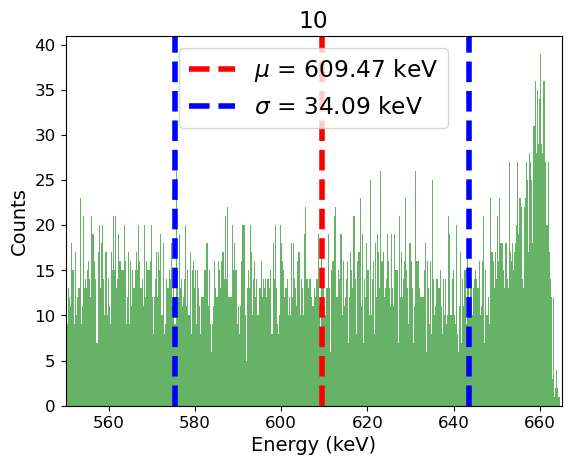

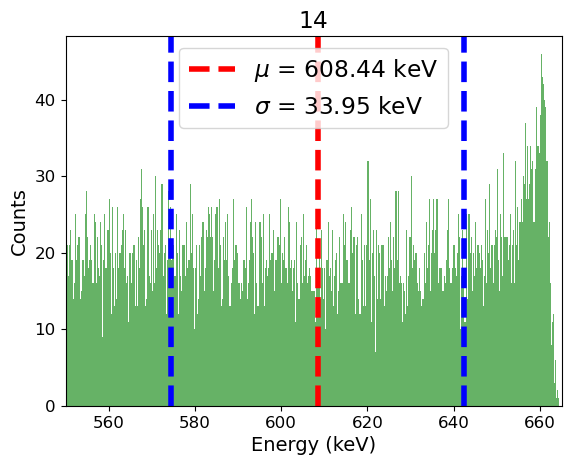

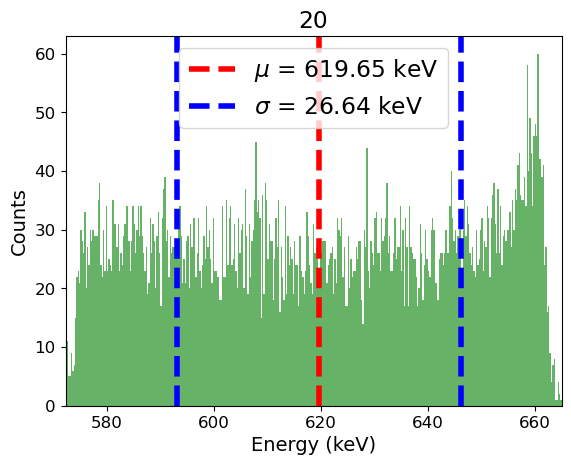

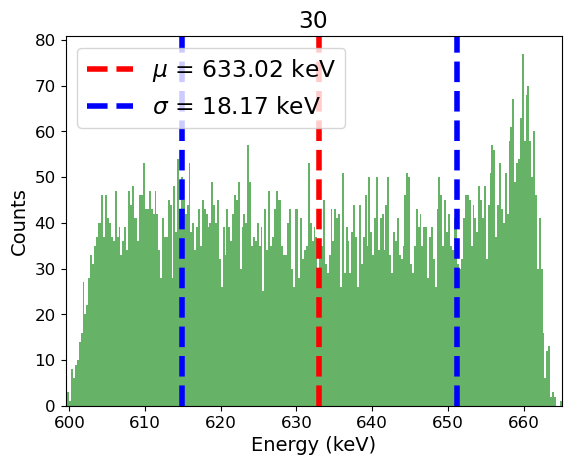

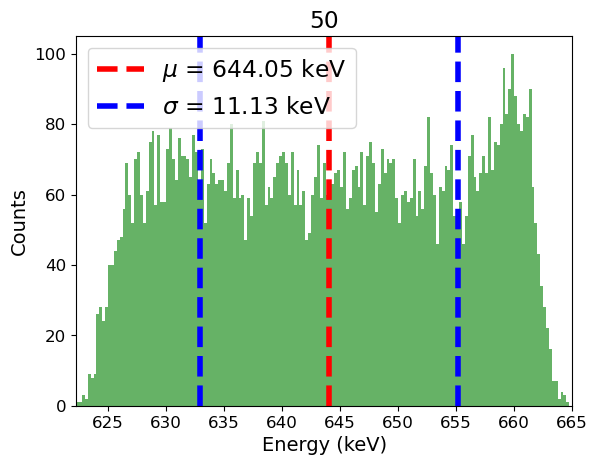

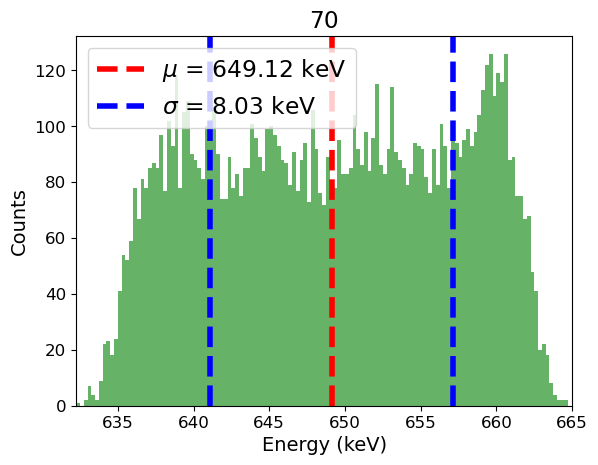

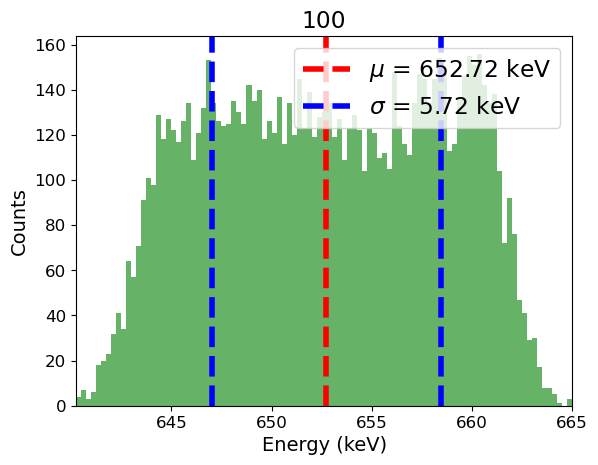

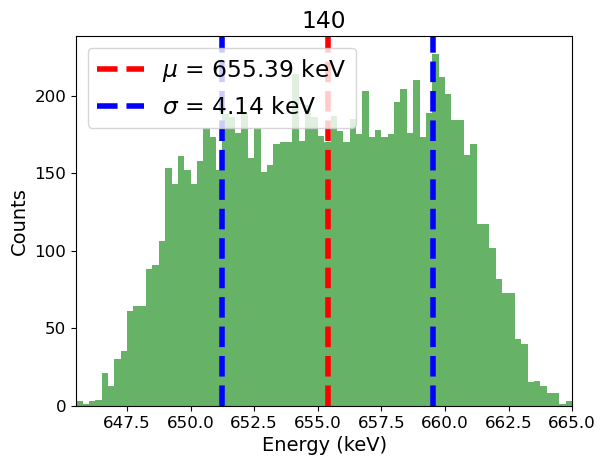

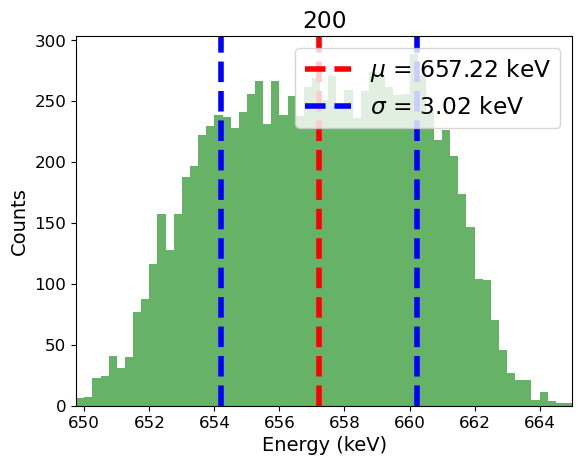

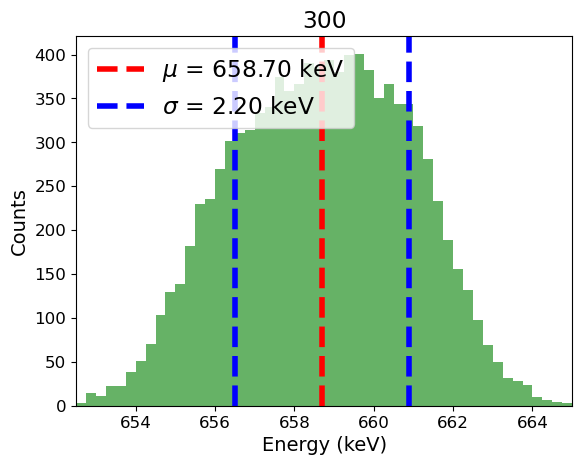

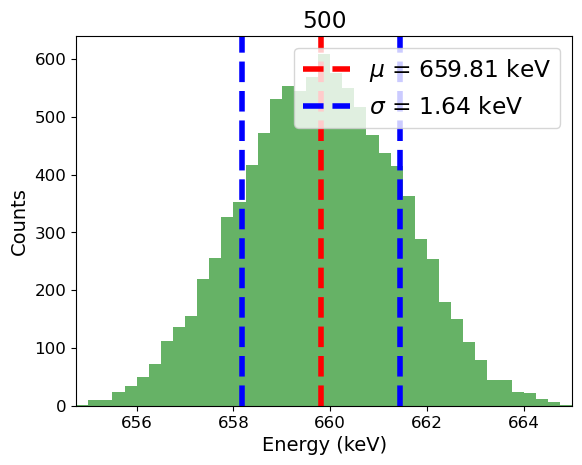

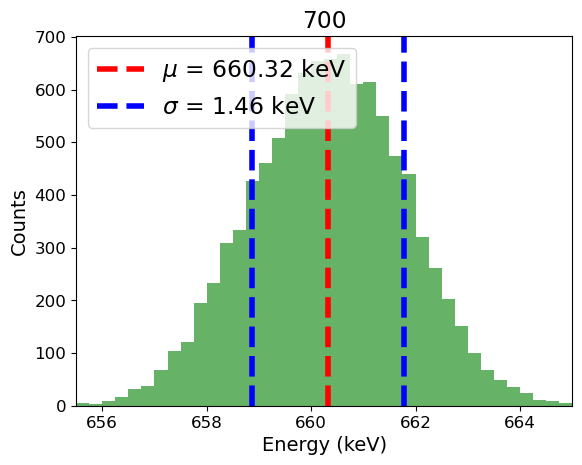

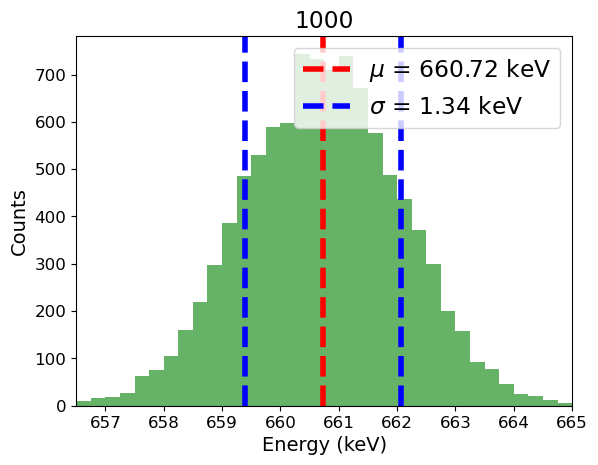

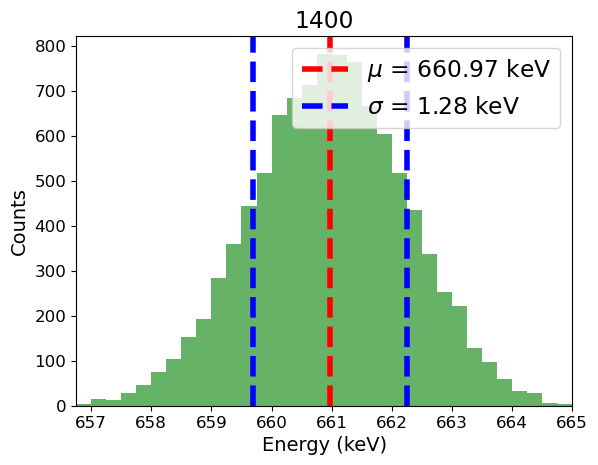

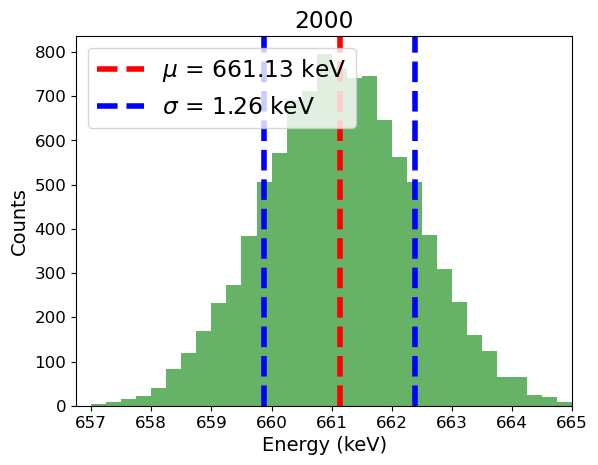

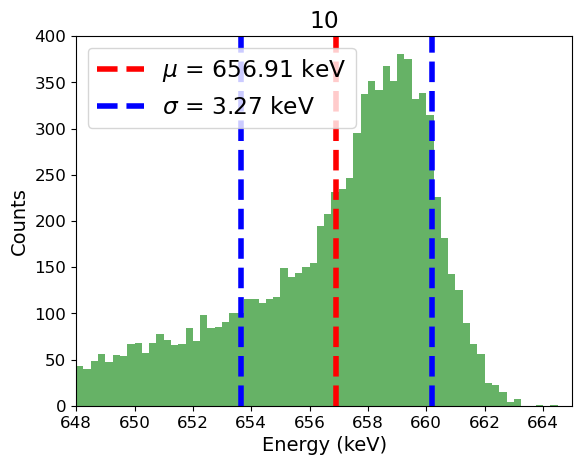

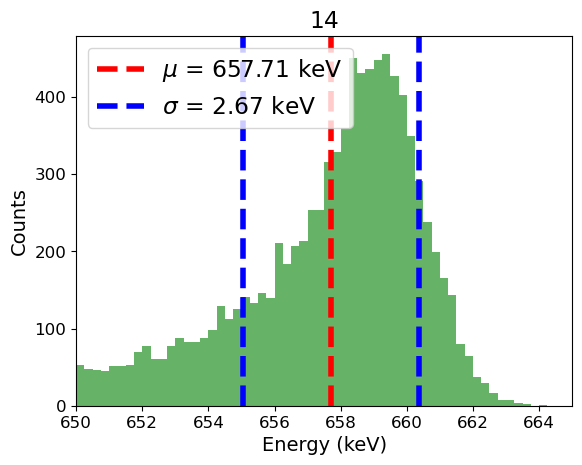

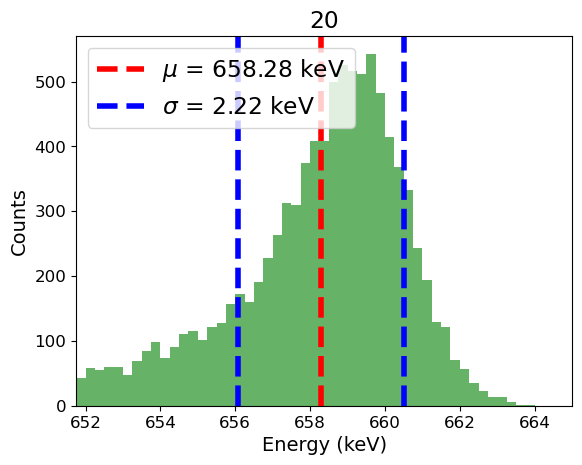

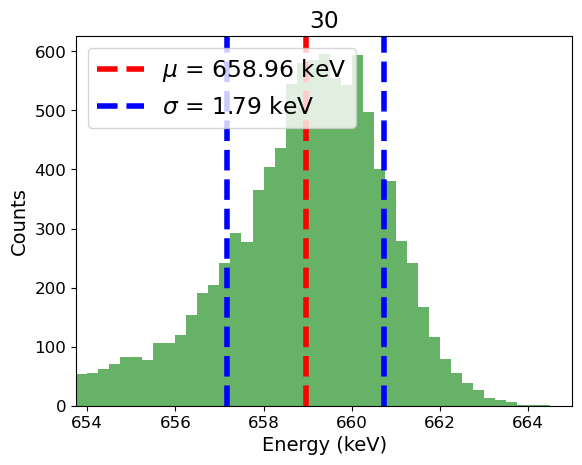

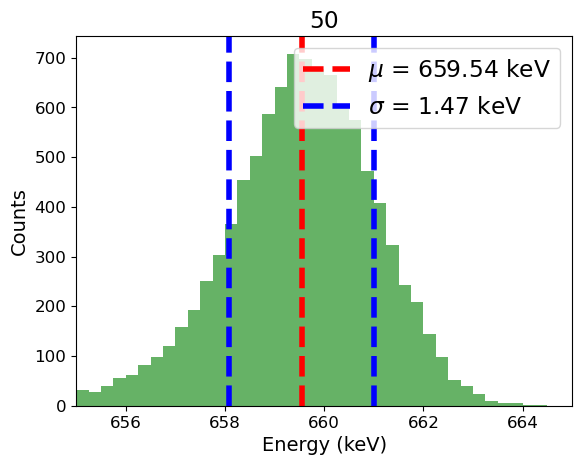

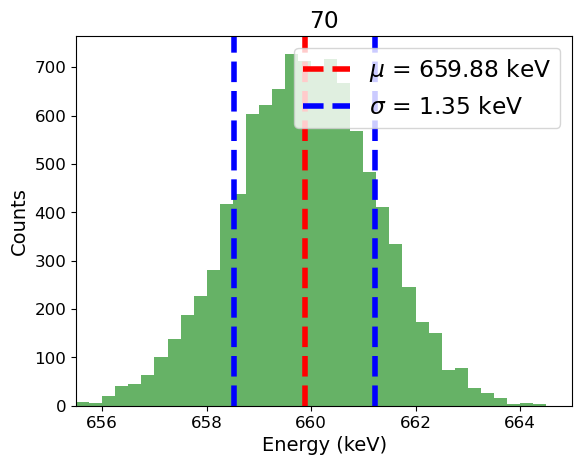

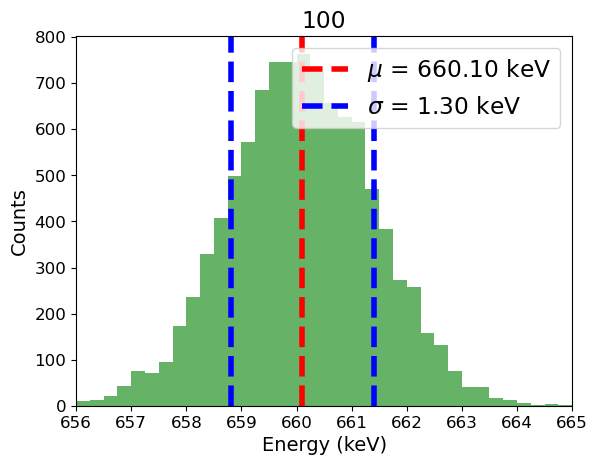

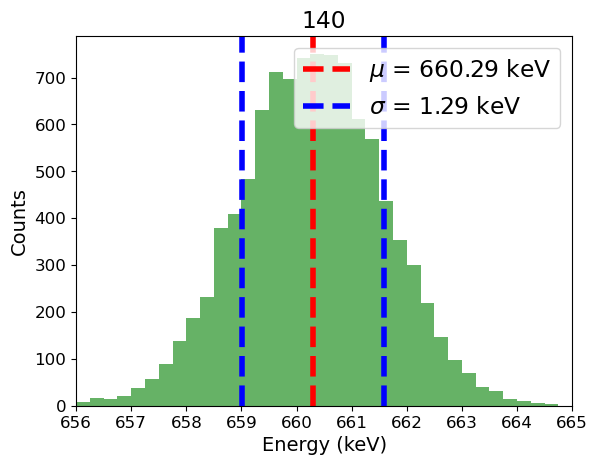

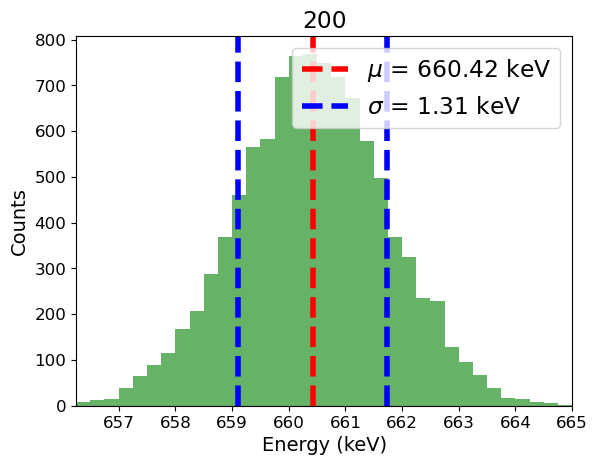

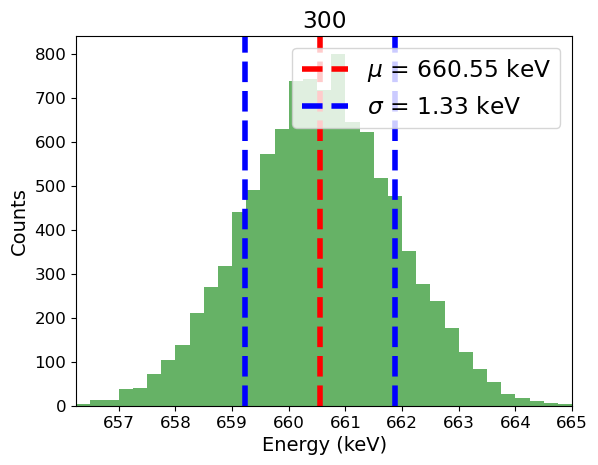

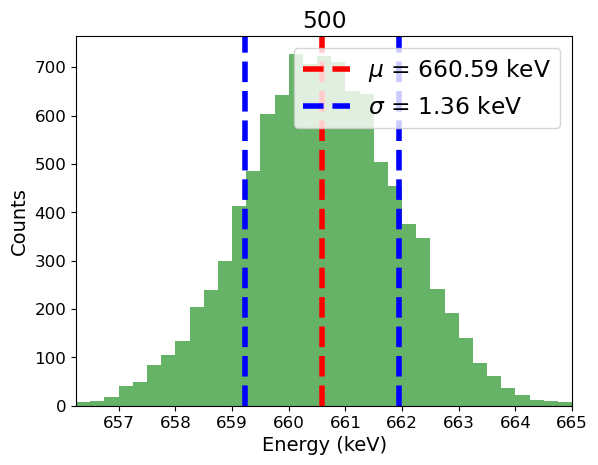

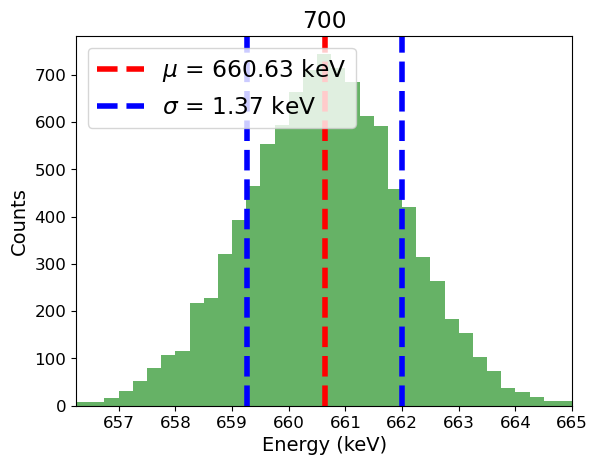

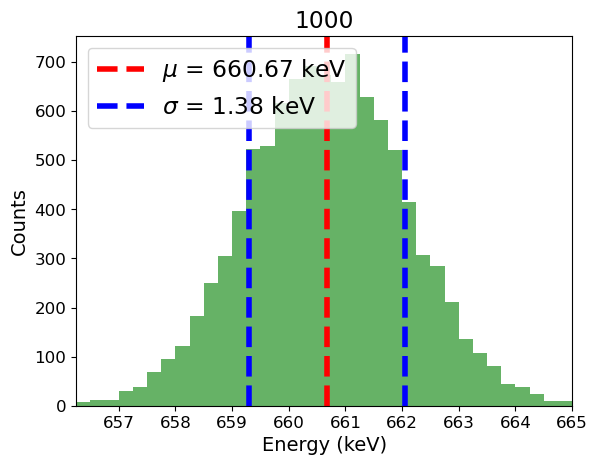

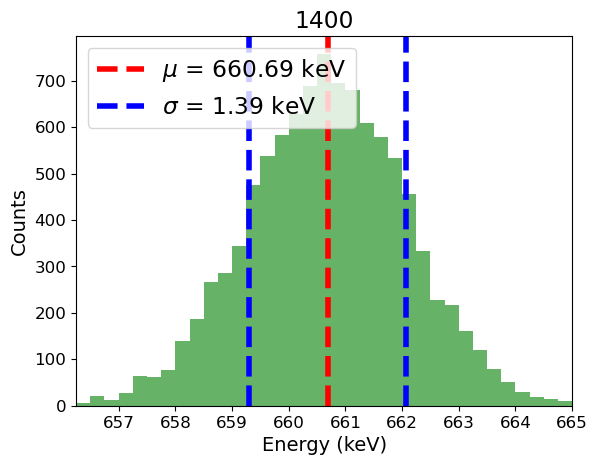

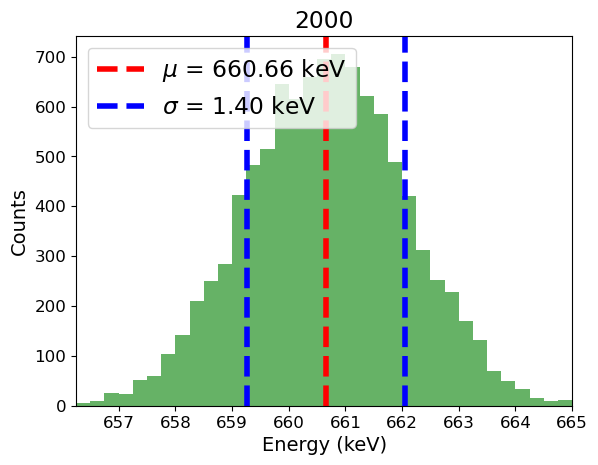

In [142]:
#we want to derive a relationship between trapping product and FWHM
#take a linear interpolation of the trapping products vs their simulated FWHM and create a function out of it:



noise=2.955
seed=1
center_value = 661.575
noised_dc_array_list = add_gaussian_noise(dc_array_list, noise, center_value, seed)
noised_ac_array_list = add_gaussian_noise(ac_array_list, noise, center_value, seed)



#measure effective FWHMs
FWHMs_dc=[]
FWHMs_ac=[]

plotting_params_DC=  list(zip(noised_dc_array_list, simulated_product_val))
plotting_params_AC=  list(zip(noised_ac_array_list, simulated_product_val))


for param in plotting_params_DC:
    #plot DC strips
    fig, axs = plt.subplots() #define subplot
    if param[1]=="Room Temperature":
        FWHMs_dc.append( mean_std(axs, param[0], param[1], RT=True)[0]) #we make special cuts for RT anneals bc the spectra are so weird
    else:
        FWHMs_dc.append( mean_std(axs, param[0], param[1])[0]) #for normal (semi-Gaussian) data sets


for param in plotting_params_AC:
    #plot AC strips 
    fig, axs = plt.subplots() #define subplot
    FWHMs_ac.append( mean_std(axs, param[0], param[1])[0]) #for normal (semi-Gaussian) data sets




[80.2718157713817, 79.95337822964801, 62.740715931458176, 42.78760396298251, 26.208214973320416, 18.90869039142721, 13.46583899658257, 9.750130057803954, 7.104814700993204, 5.188536514451467, 3.856426354096741, 3.4414803963192577, 3.151040533056012, 3.0095072535349012, 2.9568051263692343]


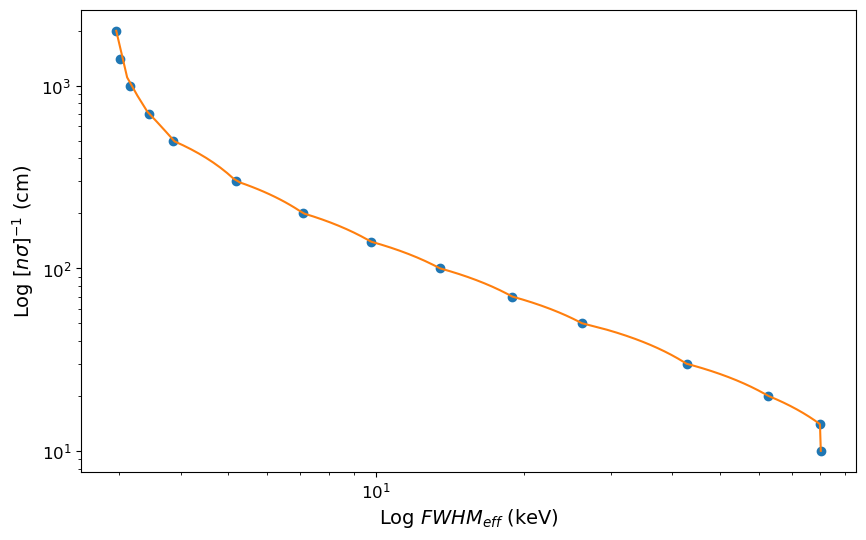

In [143]:
from scipy.interpolate import interp1d
#plot FWHM vs products for dc strips

print(FWHMs_dc)
x = np.array(FWHMs_dc)
y = np.array(simulated_product_val)

#create function of interpolation:
f_linear = interp1d(x, y, kind='linear')

# Generate new x values for a smooth curve
x_new = np.linspace(x.min(), x.max(), 500)

# Compute the interpolated y values
y_linear = f_linear(x_new)


# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(x, y, 'o', label='Data points')
plt.plot(x_new, y_linear, '-', label='Linear interpolation')
# plt.ylim(0, 60)
# plt.scatter(55, f_linear(55), color='red', label="55")
# plt.scatter(49, f_linear(49), color='green', label ='49')
#plt.title("Linear interpolation of FWHM$_{eff}$ to $[n \sigma]^{-1}$")
plt.ylabel("Log $[n \sigma]^{-1}$ (cm)", fontsize=14)
plt.xlabel("Log $FWHM_{eff}$ (keV)" , fontsize=14)
plt.tick_params(labelsize=12)
plt.yscale('log')
plt.xscale('log')
#plt.legend()


In [144]:
print(f_linear(2.9758)) #really accurate tbh 

1783.7483078693645


Below, I determine the FWHM added just by noise in our in lab data. I do this by defining a FWHM of the pre-radiation photopeak we know the trapping product of from Sean's CTD plots. Once we have the pre -rad FWHM we subtract the DC noise added in simulation to obtain the intrinsics FWHM of the simulated detector which should match our real detector (from native traps etc.). Then we subtract that value from the actual FWHM to find the FWHM attributed to noise in our detector. 

In [68]:

# Sean finds, from in lab data, our pre radiation trapping product is ~1860cm

#trying to find FWHM corresponding to 1860cm 

FWHM_0=0

min_array = np.arange(x.min(), 2.8, 0.00001)

for i in min_array:
    if np.round(f_linear(i), 1) == 1786.0: 
        FWHM_0=i

#the baseline FWHM for the simulated detector is this subtracted from the added electronic noise in quadrature

DC_noise =2.7 #as inputted by Steve in the simulations 

FWHM_intrinsic = np.sqrt( FWHM_0**2- DC_noise**2)

print(f'Instrinsic effective FWHM: {FWHM_intrinsic}') 

#our FWHM preradiation from in-lab data is:
FWHM_prerad_inlab = 2.98 #keV

#subtract intrinsic FWHM from this to get the detector noise in lab

DC_noise_inlab = np.sqrt(FWHM_prerad_inlab**2 - FWHM_intrinsic**2)
print(f'Effective FWHM of DC Noise in lab: {DC_noise_inlab}')

Instrinsic effective FWHM: nan
Effective FWHM of DC Noise in lab: nan


/var/folders/g9/70rty0x929vfgjpdhdclnn7m0000gq/T/ipykernel_4526/1642534149.py:17: RuntimeWarning: invalid value encountered in sqrt
  FWHM_intrinsic = np.sqrt( FWHM_0**2- DC_noise**2)


Now, in theory, we would know the actual noise to add to simulations. 

Ignore that for now and instead determine the relationship between in lab effective FWHM and their trapping products

trapping products (cm): [ 36.68399885  57.99907693  93.13824074 170.44002734 420.208001
 466.63490765]
Slope error: 0.0890737808199594 Intercept error: 24.884606409394305
Linear fit slope and intercept: [ 0.84758432 41.39084784]
Slope = 0.847584 +/- 0.089074 $cm hr^{-1}$


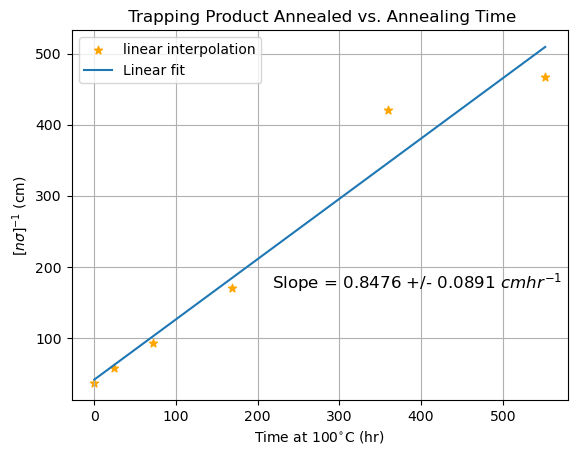

In [69]:
#Now feed the FWHM from experiment (in lab radiation and annealing) into the above function to return products corresponding to time annealing:

#define arrays of trapping products corresponding to times at 100C and their respective FWHMs
#from Cs137  radiation and annealing notebook:



FWHM_anneal = [37.246773115255806, 23.28874203901843, 14.71075686132453, 8.408072194940608, 4.387885017025085, 4.078656246666713]# effective FWHM
#FWHM_anneal_rad = 

#create labels for plotting 
labels=["anneal2", "anneal3", "anneal4", "anneal5", "anneal6", "anneal7"]

#print the trapping product for each annealing value
print(f"trapping products (cm): {f_linear(FWHM_anneal)}")

#time annealing at 100C (hr) for plotting
times =[0, 24, 72, 168, 360, 552]


##########################plot trapping products versus time annealing and take a linear fit #############################################
#for scaling the product against 
scale_factor= 1
scaled_product = f_linear(FWHM_anneal)/scale_factor

#plot product vs time annealing  scatter
plt.scatter(times, scaled_product, marker ="*", color ='orange', label ="linear interpolation")
plt.xlabel("Time at 100$^{\circ}$C (hr)")
plt.ylabel("$[n \sigma]^{-1}$ (cm) ")
#plt.ylabel("$\dfrac{[n \sigma]^{-1}}{[n \sigma]^{-1}_{0}}$ ")
plt.title(" Trapping Product Annealed vs. Annealing Time")

#Fit the data points 
# Find the linear fit (polynomial of degree 1)
coefficients, cov = np.polyfit(times,scaled_product , 1, cov=True)

#compute errors
slope_error= np.sqrt(np.diag(cov))[0]
intercept_error = np.sqrt(np.diag(cov))[1]

print("Slope error: "+ str(slope_error), "Intercept error: " + str(intercept_error))


# Create a polynomial function from the coefficients
linear_fit = np.poly1d(coefficients)

# Generate new x values/times for the fit line
times_new = np.linspace(np.array(times).min(), np.array(times).max(), 500)

# Compute the y values/trapping products for the fit line
y_fit = linear_fit(times_new)

#plot the fit 
plt.plot(times_new, y_fit, label ="Linear fit ")


# Print the coefficients
print(f"Linear fit slope and intercept: {coefficients}")

plt.text(times[3]+50, scaled_product[3], "Slope = " + str(round(coefficients[0], 4) )+ " +/- "+str(round(slope_error, 4)) +" $cm hr^{-1}$", fontsize=12)
#plt.text(times[3]+50, scaled_product[3]-0.05, "$[n \sigma]^{-1}_{0} = "+str(scale_factor)+" cm$", fontsize=12)
print("Slope = " + str(round(coefficients[0], 6) )+ " +/- "+str(round(slope_error, 6)) +" $cm hr^{-1}$")

plt.legend()
plt.grid()


In [100]:
def exponential_decay2(t, A, tau, C):
    return A * np.exp(-t / tau) + C

def decayfit(x_data, y_data, y_err, A_init, tau_init, C_value, xmin, xmax):
    x_array = np.array(x_data)
    y_array = np.array(y_data)
    y_err_array = np.array(y_err)
    
    initial_guess = [A_init, tau_init, C_value]
    bounds = ([0, 0, 0], [np.inf, np.inf, y_data[-1]])  # Allow all parameters to vary
    
    popt, pcov = curve_fit(exponential_decay2, x_array, y_array, p0=initial_guess, sigma=y_err,  bounds=bounds)#,
    A_fit, tau_fit, C_fit = popt
    
    errors = np.sqrt(np.diag(pcov))  # Standard deviations of fitted parameters
    A_err, tau_err, C_err = errors
    
     
    x_continuous = np.linspace(xmin, xmax, 100)
    y_continuous = exponential_decay2(x_continuous, A_fit, tau_fit, C_fit)
    
    ################ chi sqaured calculation ############################################################
    # Generate fitted curve
    y_fit = exponential_decay2(x_array, A_fit, tau_fit, C_fit)
    # Compute residuals
    residuals = y_array - y_fit
    

    # Estimate error per data point (assuming constant error if not given)
    sigma = y_err #[x * 40 for x in y_err] #alter sigma st we get chi squared of 1 when fitting is defaulted to scale

    # Compute chi-squared
    chi_squared = np.sum((residuals / sigma) ** 2)
    reduced_chi_squared = chi_squared / (len(x_array) - len(popt))  # Reduced χ²
    
    ########################################################################################################
    
   
    print(f"Decay Constant (τ): {-tau_fit} ± {tau_err}")
    print(f"Amplitude (A): {A_fit} ± {A_err}")
    print(f"Constant (C): {C_fit} ± {C_err}")
    print(f"Chi-Squared: {chi_squared:.2f}")
    print(f"Reduced Chi-Squared: {reduced_chi_squared:.2f}")
    
    
    # Compute uncertainty bounds separately for A, C, and tau
    y_upper_tau = exponential_decay2(x_continuous, A_fit, tau_fit + tau_err, C_fit)
    y_lower_tau = exponential_decay2(x_continuous, A_fit, tau_fit - tau_err, C_fit)
    y_upper_C = exponential_decay2(x_continuous, A_fit, tau_fit, C_fit + C_err)
    y_lower_C = exponential_decay2(x_continuous, A_fit, tau_fit, C_fit - C_err)
    y_upper_A = exponential_decay2(x_continuous, A_fit + A_err, tau_fit, C_fit)
    y_lower_A = exponential_decay2(x_continuous, A_fit - A_err, tau_fit, C_fit)
    
    return x_continuous, y_continuous, tau_fit, A_fit, C_fit, y_upper_tau, y_lower_tau, y_upper_C, y_lower_C, y_upper_A, y_lower_A, tau_err, C_err

def exp_plot(x_data, y_data, y_err, A_init, tau_init, C_value, xmin, xmax, ymin, ymax, xlabel, ylabel, labels=False):
    plt.figure(figsize=(8, 6))
    
    x_fit, y_fit, tau_fit, A_fit, C_fit, y_upper_tau, y_lower_tau, y_upper_C, y_lower_C, y_upper_A, y_lower_A, tau_err, C_err = decayfit(x_data, y_data,y_err, A_init, tau_init, C_value, xmin, xmax)
    
    print(f"Decay Constant: {-tau_fit}\nAmp: {A_fit}\nConstant: {C_fit}")
    
     # Scatter plot of data points with error bars
    plt.errorbar(x_data, y_data, yerr=y_err, fmt='o', label='Data', capsize=3)
    
    plt.scatter(x_data, y_data, label="Data", color='blue')
    plt.plot(x_fit, y_fit, 'r', label='Exponential Fit')
    
    # Plot separate uncertainty bounds for A, C, and tau
    plt.fill_between(x_fit, y_lower_tau, y_upper_tau, color='blue', alpha=0.2, label='Tau Uncertainty')
    plt.fill_between(x_fit, y_lower_C, y_upper_C, color='green', alpha=0.2, label='C Uncertainty')
    plt.fill_between(x_fit, y_lower_A, y_upper_A, color='purple', alpha=0.2, label='Amplitude Uncertainty')
    
    if labels:
        # Labels for data points
        for i, label in enumerate(labels):
            if i!=len(labels)-1:
                plt.text(x_data[i] + 70, y_data[i] + 0.025, label, ha='right', fontsize=11)
            else:
                print(x_data[-1], y_data[-1] )
                plt.text(x_data[-1]-5 , y_data[-1] + 0.030, label, ha='right', fontsize=11)
   #Display chi-squared value in the plot
#     plt.text(
#         xmin + 5, ymin + (ymax - ymin) * 0.1,  
#         f"χ² = {chi_squared:.2f}\nReduced χ² = {reduced_chi_squared:.2f}", 
#         fontsize=12, bbox=dict(facecolor='white', alpha=0.5)
#     )
    
    plt.ylabel(ylabel, fontsize=12)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylim(ymin, ymax)
    plt.xlim(xmin-10, xmax)
    
    plt.grid(True)
    plt.legend()
    plt.show()

('Anneal 2', 36.6839988508402)cm
('Anneal 3', 57.99907693041782)cm
('Anneal 4', 93.13824074314549)cm
('Anneal 5', 170.44002733529717)cm
('Anneal 6', 420.20800099793195)cm
('Anneal 7', 466.6349076549652)cm
Decay Constant (τ): -67.9191605654133 ± 12.758079362361666
Amplitude (A): 0.8832135828876359 ± 0.06188585388173428
Constant (C): 0.07861391903831748 ± 0.039233663399297174
Chi-Squared: 3.19
Reduced Chi-Squared: 1.06
Decay Constant: -67.9191605654133
Amp: 0.8832135828876359
Constant: 0.07861391903831748
552 0.07861391903831749


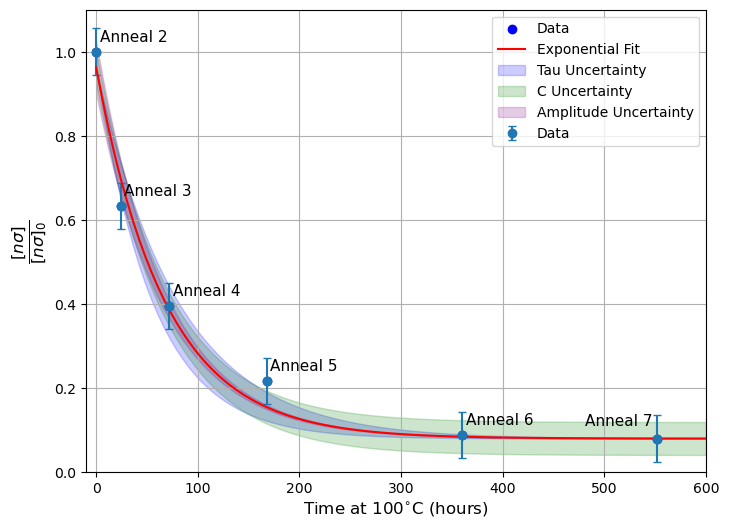

In [101]:
####################### fit an exponential function to the decay of hole traps with time spent annealing at 100C ##################################################################

times =[0, 24, 72, 168, 360, 552]
scale_factor = f_linear(FWHM_anneal[0]) #scale by post anneal 2 trapping product 

#scale the trapping product s.t we are tracking pecentage of traps on the y axis 
scaled_product = scale_factor/f_linear(FWHM_anneal)

labels=['Anneal 2', 'Anneal 3', 'Anneal 4', 'Anneal 5', 'Anneal 6', 'Anneal 7']

for item in zip(labels, f_linear(FWHM_anneal)):
    print(f'{item}cm')

#plt.axhline(scale_factor/f_linear_rad(50.36), color='r', linestyle = "--", label = "post rad 2")
errors=[0.0555]*6
exp_plot(times, scaled_product, errors,  0.6, 100.0, 0.05, 0, 600, 0, 1.1,"Time at 100$^{\circ}$C (hours)" , "$\dfrac{[n \sigma]}{[n \sigma]_0}$ " , labels=labels)


Decay Constant (τ): -116.75003393802386 ± 14.364177535894923
Amplitude (A): 0.606153689368767 ± 0.04530511035587519
Constant (C): 0.06774322801368345 ± 0.011056297107550092
Chi-Squared: 1.02
Reduced Chi-Squared: 1.02
Decay Constant: -116.75003393802386
Amp: 0.606153689368767
Constant: 0.06774322801368345
552 0.07861391903831749


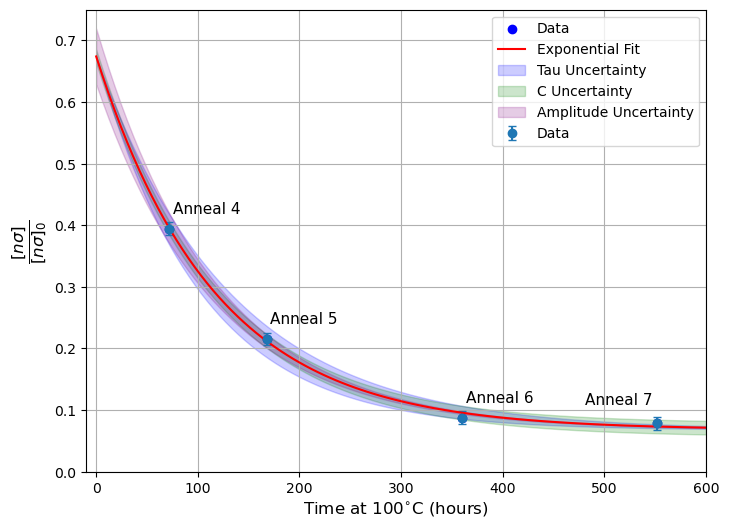

In [102]:
errors=[0.0105]*6
exp_plot(times[2:6], scaled_product[2:6], errors[2:6],  0.6, 100.0, 0.05, 0, 600, 0, 0.75,"Time at 100$^{\circ}$C (hours)" , "$\dfrac{[n \sigma]}{[n \sigma]_0}$ " , labels=labels[2:6])


Decay Constant (τ): -116.75003393802386 ± 14.364177535894923
Amplitude (A): 0.606153689368767 ± 0.04530511035587519
Constant (C): 0.06774322801368345 ± 0.011056297107550092
Chi-Squared: 1.02
Reduced Chi-Squared: 1.02
Decay Constant: -116.75003393802386
Amp: 0.606153689368767
Constant: 0.06774322801368345
552 0.07861391903831749


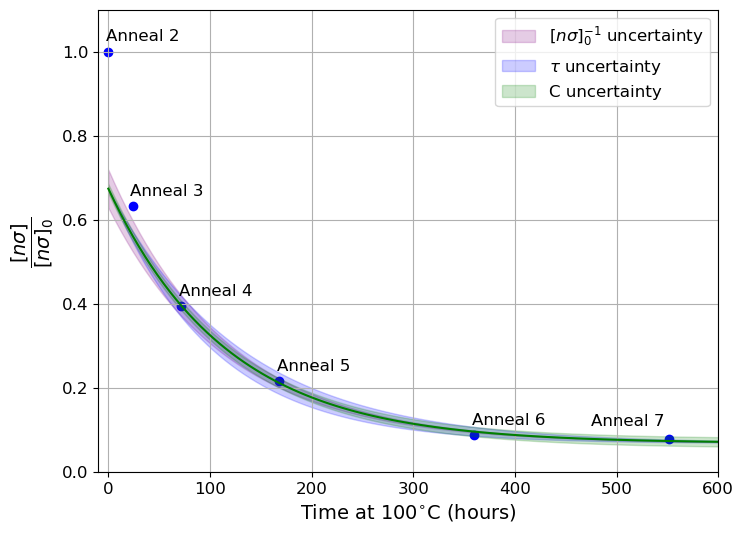

In [120]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def decayfit(x_data, y_data, y_err, A_init, tau_init, C_value, xmin, xmax):
    # Use all data points for visualization but exclude the first two in the fitting
    x_array = np.array(x_data[2:])
    y_array = np.array(y_data[2:])
    y_err_array = np.array(y_err[2:])
    
    initial_guess = [A_init, tau_init, C_value]
    bounds = ([0, 0, 0], [np.inf, np.inf, y_data[-1]])  # Allow all parameters to vary
    
    popt, pcov = curve_fit(exponential_decay2, x_array, y_array, p0=initial_guess, sigma=y_err_array, bounds=bounds)
    A_fit, tau_fit, C_fit = popt
    
    errors = np.sqrt(np.diag(pcov))  # Standard deviations of fitted parameters
    A_err, tau_err, C_err = errors
    
    x_continuous = np.linspace(xmin, xmax, 100)
    y_continuous = exponential_decay2(x_continuous, A_fit, tau_fit, C_fit)
    
    ################ Chi-Squared Calculation ############################################################
    # Generate fitted curve
    y_fit = exponential_decay2(x_array, A_fit, tau_fit, C_fit)
    # Compute residuals
    residuals = y_array - y_fit

    # Compute chi-squared
    chi_squared = np.sum((residuals / y_err_array) ** 2)
    reduced_chi_squared = chi_squared / (len(x_array) - len(popt))  # Reduced χ²
    
    ########################################################################################################
   
    print(f"Decay Constant (τ): {-tau_fit} ± {tau_err}")
    print(f"Amplitude (A): {A_fit} ± {A_err}")
    print(f"Constant (C): {C_fit} ± {C_err}")
    print(f"Chi-Squared: {chi_squared:.2f}")
    print(f"Reduced Chi-Squared: {reduced_chi_squared:.2f}")
    
    # Compute uncertainty bounds separately for A, C, and tau
    y_upper_tau = exponential_decay2(x_continuous, A_fit, tau_fit + tau_err, C_fit)
    y_lower_tau = exponential_decay2(x_continuous, A_fit, tau_fit - tau_err, C_fit)
    y_upper_C = exponential_decay2(x_continuous, A_fit, tau_fit, C_fit + C_err)
    y_lower_C = exponential_decay2(x_continuous, A_fit, tau_fit, C_fit - C_err)
    y_upper_A = exponential_decay2(x_continuous, A_fit + A_err, tau_fit, C_fit)
    y_lower_A = exponential_decay2(x_continuous, A_fit - A_err, tau_fit, C_fit)
    
    return x_continuous, y_continuous, tau_fit, A_fit, C_fit, y_upper_tau, y_lower_tau, y_upper_C, y_lower_C, y_upper_A, y_lower_A, tau_err, C_err, chi_squared, reduced_chi_squared

def exp_plot(x_data, y_data, y_err, A_init, tau_init, C_value, xmin, xmax, ymin, ymax, xlabel, ylabel, labels=False):
    plt.figure(figsize=(8, 6))
    
    x_fit, y_fit, tau_fit, A_fit, C_fit, y_upper_tau, y_lower_tau, y_upper_C, y_lower_C, y_upper_A, y_lower_A, tau_err, C_err, chi_squared, reduced_chi_squared = decayfit(x_data, y_data, y_err, A_init, tau_init, C_value, xmin, xmax)
    
    print(f"Decay Constant: {-tau_fit}\nAmp: {A_fit}\nConstant: {C_fit}")
    
    # Scatter plot of all data points with error bars
    #plt.errorbar(x_data, y_data, yerr=y_err, fmt='o',  capsize=3)
    plt.scatter(x_data, y_data,  color='blue')
    
    # Plot the fitted exponential curve (excluding first two data points in fitting)
    plt.plot(x_fit, y_fit, 'g')
    
    # Plot separate uncertainty bounds for A, C, and tau
    plt.fill_between(x_fit, y_lower_A, y_upper_A, color='purple', alpha=0.2, label=r'$[n\sigma]_0^{-1}$ uncertainty')
    plt.fill_between(x_fit, y_lower_tau, y_upper_tau, color='blue', alpha=0.2, label=r'$\tau$ uncertainty')
    plt.fill_between(x_fit, y_lower_C, y_upper_C, color='green', alpha=0.2, label='C uncertainty')
    
    if labels:
        # Labels for data points
        for i, label in enumerate(labels):
            if i != len(labels) - 1:
                plt.text(x_data[i] + 70, y_data[i] + 0.025, label, ha='right', fontsize=12)
            else:
                print(x_data[-1], y_data[-1])
                plt.text(x_data[-1] - 5, y_data[-1] + 0.030, label, ha='right', fontsize=12)

#     # Display chi-squared value in the plot
#     plt.text(
#         xmin + 5, ymin + (ymax - ymin) * 0.1,  
#         f"χ² = {chi_squared:.2f}\nReduced χ² = {reduced_chi_squared:.2f}", 
#         fontsize=12, bbox=dict(facecolor='white', alpha=0.5)
#     )
    
    plt.ylabel(ylabel, fontsize=14)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylim(ymin, ymax)
    plt.xlim(xmin - 10, xmax)
    plt.tick_params(labelsize=12)
    
    plt.grid(True)
    plt.legend(fontsize=12)
    plt.show()

exp_plot(times, scaled_product, errors,  0.6, 100.0, 0.05, 0, 600, 0, 1.1,"Time at 100$^{\circ}$C (hours)" , "$\dfrac{[n \sigma]}{[n \sigma]_0}$ " , labels=labels)


Now we compare simulated photopeaks to experimental photopeaks to demonstrate the effects of secondary damage (from room temp cycling) that is not captured by our simulations. 

Here I import data to compare simulated and real peak shapes:

In [72]:
data = np.load('arrays_file.npz')

# Access the arrays using their names
rad1 = data['dc_93']
rad2=data['dc_38']
anneal1 = data['dc_25']
anneal2 = data['dc_39']
anneal3 = data['dc_55']
anneal4 = data['dc_88']
anneal5= data['dc_156']
anneal6 = data['dc_301']
anneal7 = data['dc_401']


In [167]:
def multi_spline(ax, energies, min_energy, max_energy, min_count, max_count,  exposure_time_list, label_list, colors= ["black"]+ sns.color_palette("husl", 10), title="", log=False, Q_factor=False, vline=False, splineline=False): 
    
    #import libraries needed for this function
    from scipy.interpolate import UnivariateSpline
    from scipy.signal import find_peaks
    import seaborn as sns 
    

    #fig, axs = plt.subplots(1, 1, figsize=(24,12))

    #define list of bins for each hist s.t there are 4 bins per keV:
    bin_num = []
    for i in energies:
        bin = int((np.max(i)-np.min(i)))*2
        bin_num.append(bin)

    #empty list for tracking Q factor among anneals
    Q_list=[]

    for i in range(len(energies)):
    
        #define histogram
        hist,binedges,_  = plt.hist(energies[i], histtype="step", bins=bin_num[i],weights=np.full_like(energies[i], 0.5/exposure_time_list[i]), color=colors[i])
    
        #plot a spline for the hist 
        bin_centers = np.array((binedges[:-1] + binedges[1:]) / 2)
        n, bins, patches = ax.hist(energies[i],histtype="step",linewidth=2,  bins=bin_num[i], weights=np.full_like(energies[i], 0.5/exposure_time_list[i]), label =label_list[i], color=colors[i])
        spline = UnivariateSpline(bin_centers, n)
        if splineline==True:
            ax.plot(bin_centers, spline (bin_centers), color = 'red',linestyle ='--', label='spline')
        
        if Q_factor== True:
            #find Q factor:  Q = (662-second peak)/height of second peak

            #find the second peak by considering just the lower half of the hist
            condition = bin_centers < 655.0
            lowbins = bin_centers[condition]
            lowcounts = n[condition]
            
            # Find the maximum counts from this range
            second_max = np.max(lowcounts)

            #now find the location of the max counts
            second_max_index = np.where(n == second_max)[0][0]  
            second_peak = bin_centers[second_max_index]
        
            Q = (661.7 - second_peak)/second_max
            print("Q-factor for", label_list[i], Q)
            Q_list.append(Q)
        
                
        #integrate for total counts
    
        integral_spline = spline.integral(bin_centers[0], bin_centers[-1])
        #print(f"Integral (UnivariateSpline): {integral_spline:.4f}")
        #print(label_array[i])
    
    
    #for log plots if you want to 
    if log == True:
        plt.yscale('log')
    
    #label axes
    ax.set_xlabel('Energy (keV)', fontsize=38.)
    ax.set_ylabel('Counts $min^{-1}$', fontsize=38.)
    
    if vline==True:
    	plt.axvline(661.7, ls ="--", color = '#ff7f0e', lw=3) 


    #ax.legend(fontsize=28.0, loc='upper left')
    ax.grid()
    ax.tick_params(labelsize=32.)
    ax.set_xlim(min_energy, max_energy)
    ax.set_ylim(min_count, max_count)
    ax.set_title(title, fontsize=44)
    
    #plt.show()
    
    if Q_factor==True:
        return Q_list


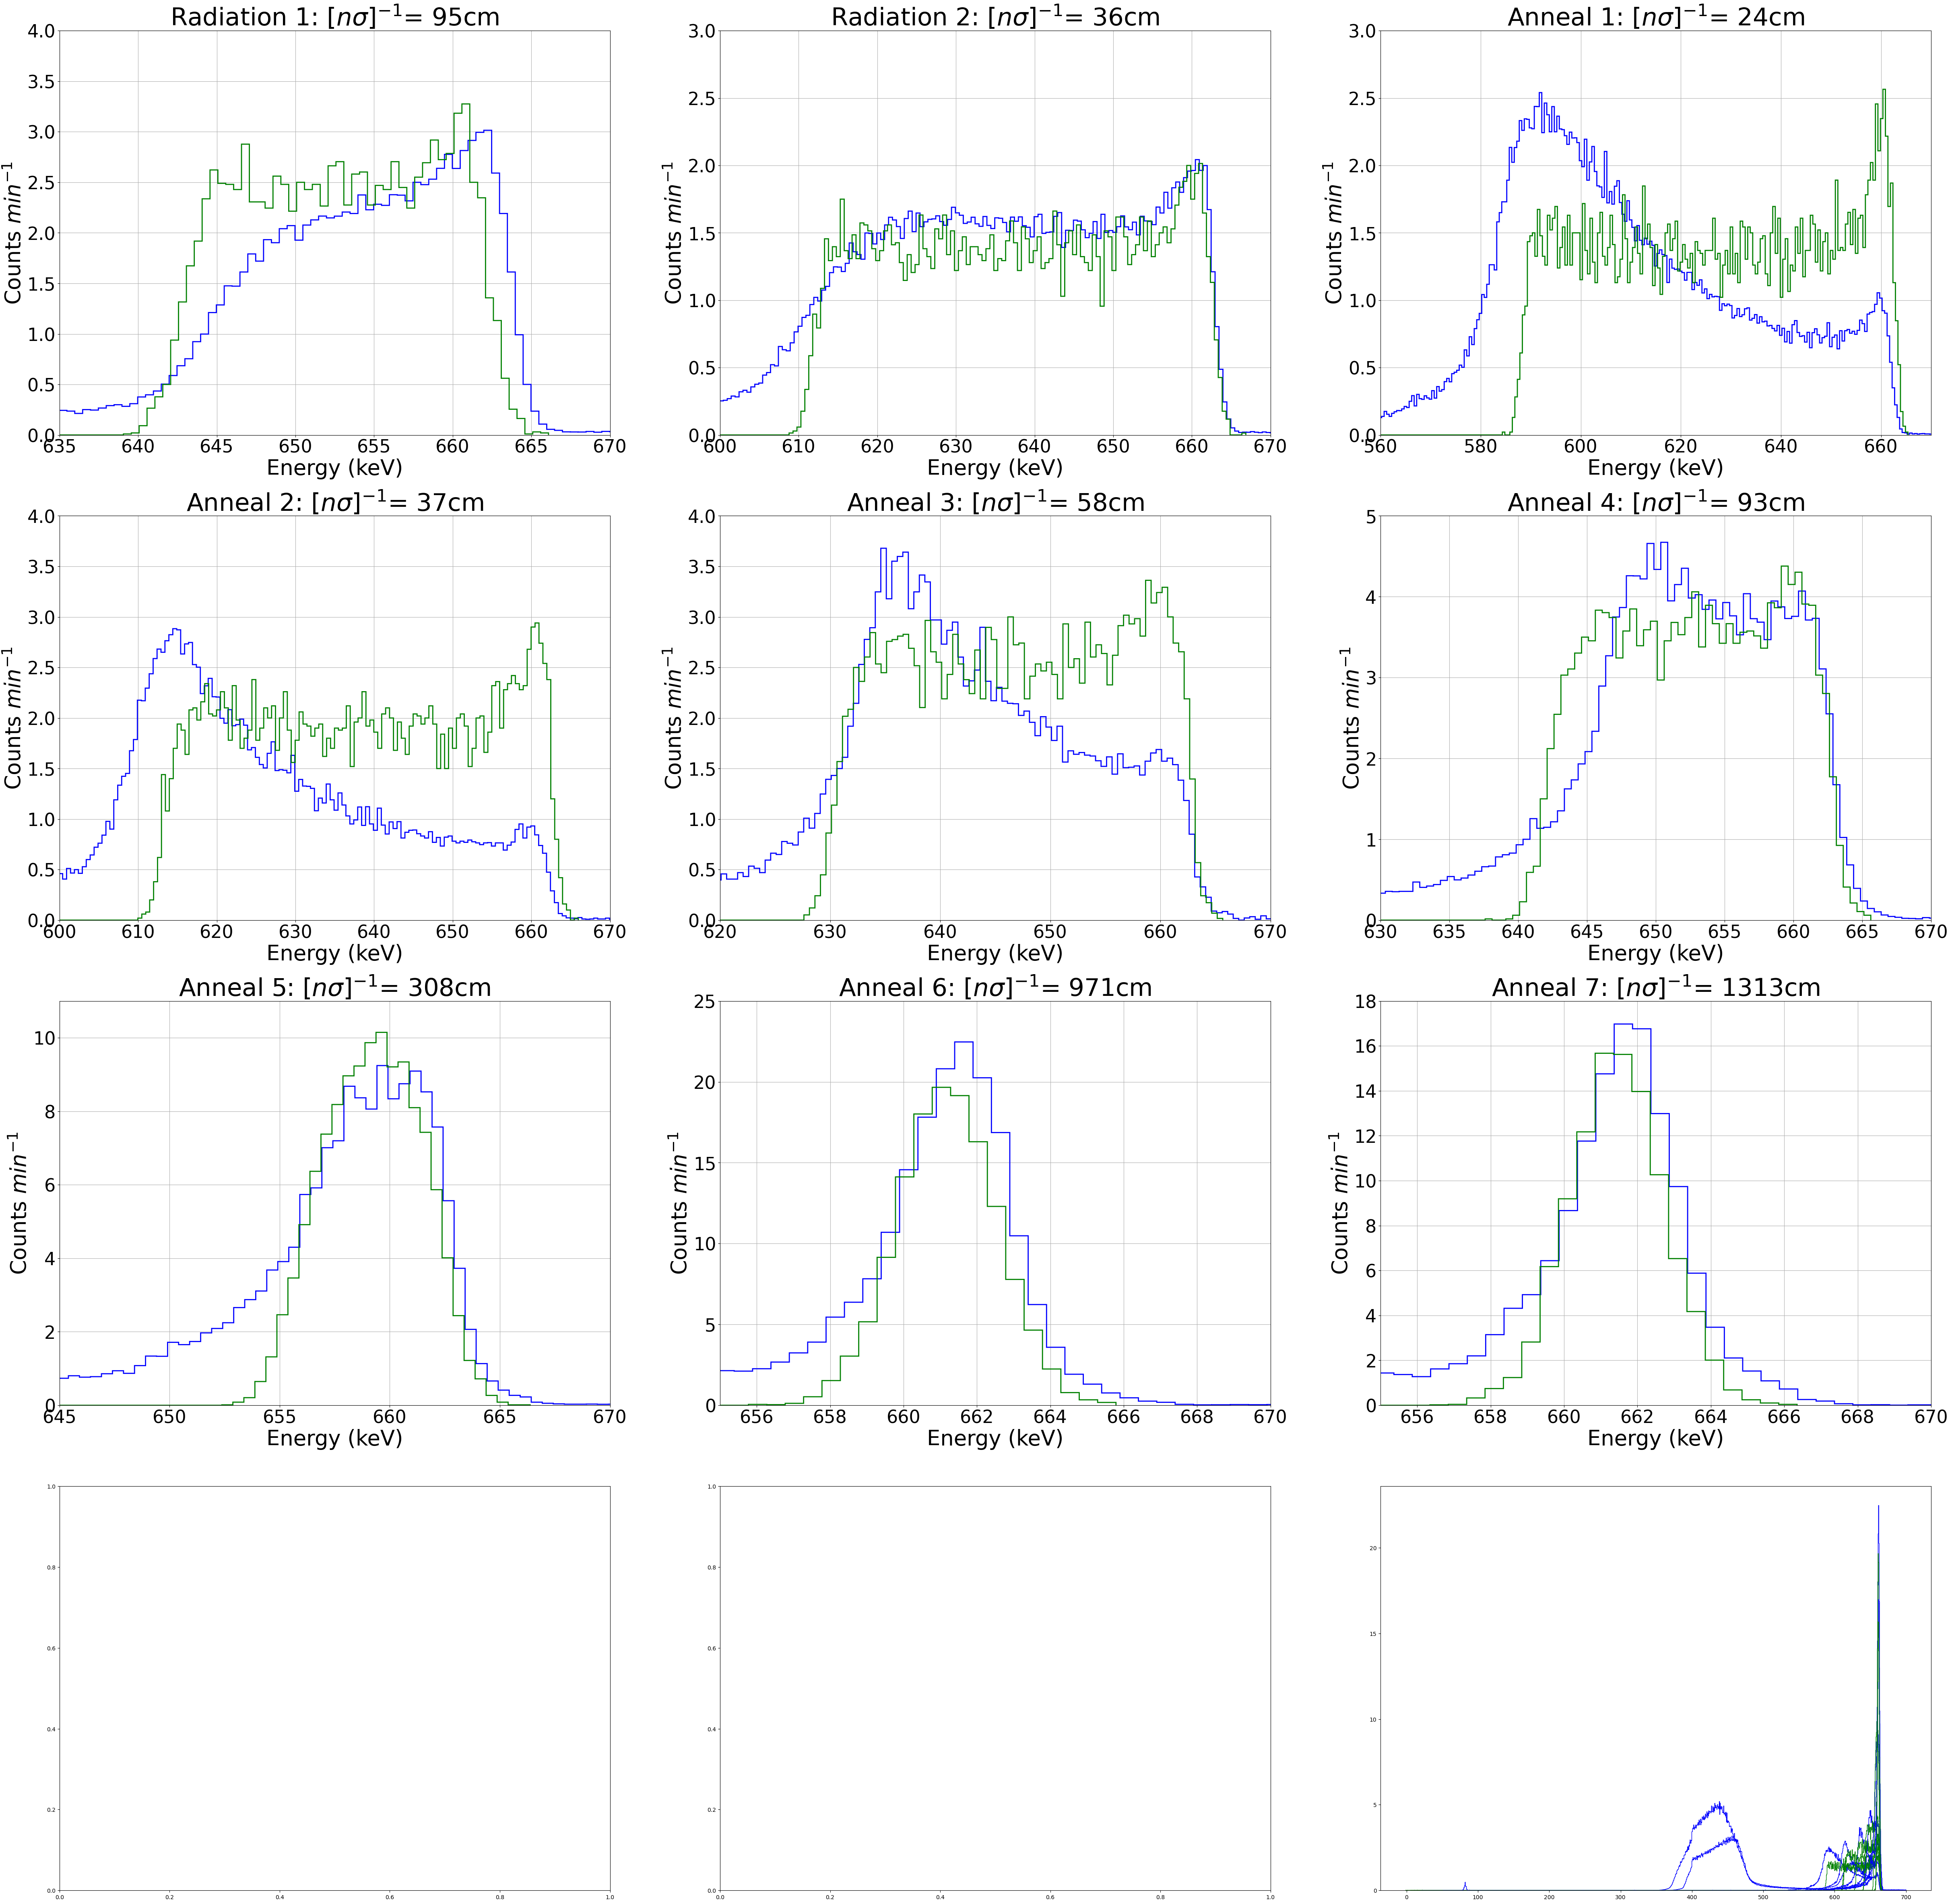

In [168]:

exp_peaks=[rad1,rad2, anneal1, anneal2, anneal3, anneal4,  anneal5, anneal6, anneal7] 
exposure_time_list=[ 2308,1618,380, 176, 117, 243, 183, 236, 80]
title_list=["Radiation 1: $[n \sigma]^{-1} $= 95cm","Radiation 2: $[n \sigma]^{-1} $= 36cm", "Anneal 1: $[n \sigma]^{-1} $= 24cm","Anneal 2: $[n \sigma]^{-1} $= 37cm","Anneal 3: $[n \sigma]^{-1} $= 58cm", "Anneal 4: $[n \sigma]^{-1} $= 93cm",  "Anneal 5: $[n \sigma]^{-1} $= 308cm", "Anneal 6: $[n \sigma]^{-1} $= 971cm", "Anneal 7: $[n \sigma]^{-1} $= 1313cm"]
scale=1
count_list=[4, 3, 3, 4, 4, 5, 11, 25, 18]
sim_exposure_time=[49, 34, 23, 25, 29, 33, 41, 37, 49]
lower_bounds= [635, 600, 560, 600,620, 630, 645, 655, 655]

fig, axes = plt.subplots(4, 3, figsize=(60, 60))
axes = axes.flatten()

noised_exp_dc_array_list = add_gaussian_noise(exp_dc_array_list, noise, center_value, seed)

for i in range(len(noised_exp_dc_array_list)):
    

    min_energy=lower_bounds[i]
    max_energy=670
    min_count=0
    max_count= count_list[i]
    exposure_time = [exposure_time_list[i], sim_exposure_time[i]]
    
    energies=[exp_peaks[i],noised_exp_dc_array_list[i]+0.5]
    label_list=['Experimental', 'Simulated']
    color_list=['blue', 'green']
    #print(i, )
    
    
    
    multi_spline(axes[i], energies, min_energy, max_energy, min_count, max_count, exposure_time, label_list, colors=color_list ,title=title_list[i])

[38, 93, 25, 39, 55, 88, 156, 301, 401]


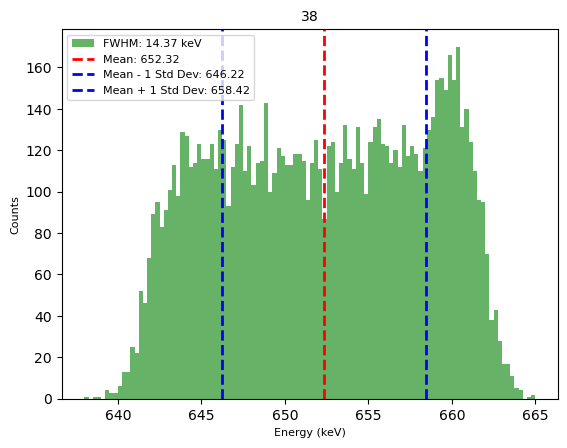

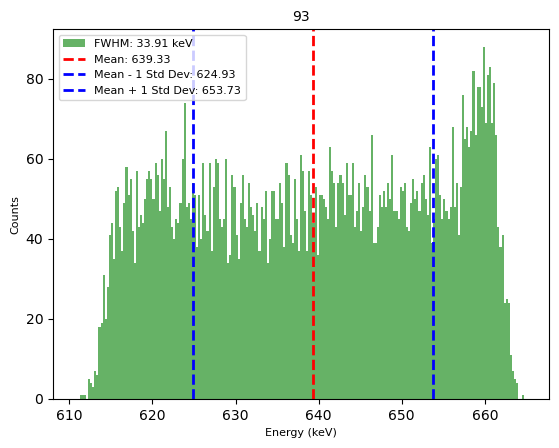

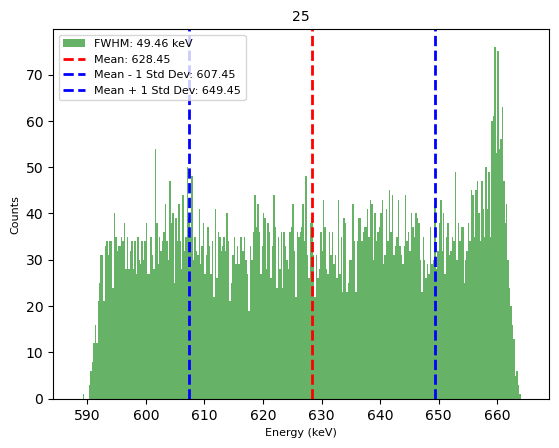

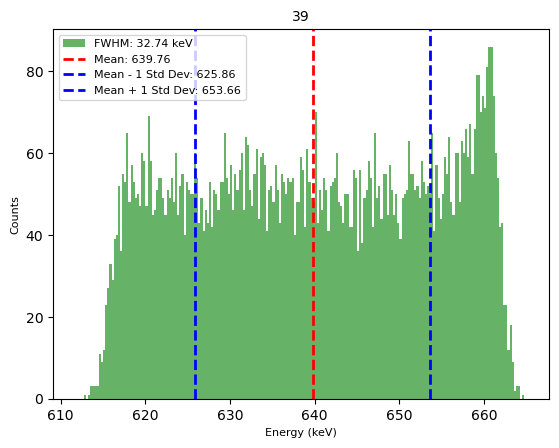

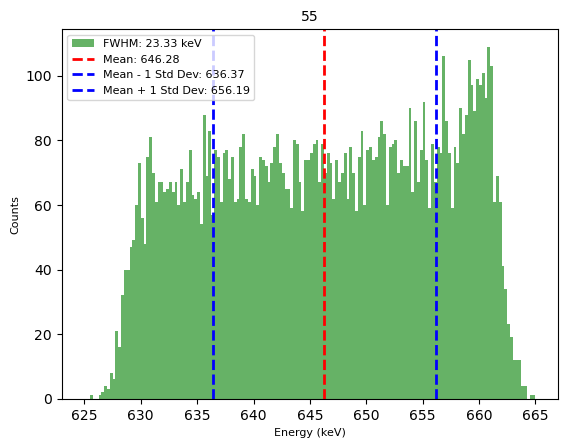

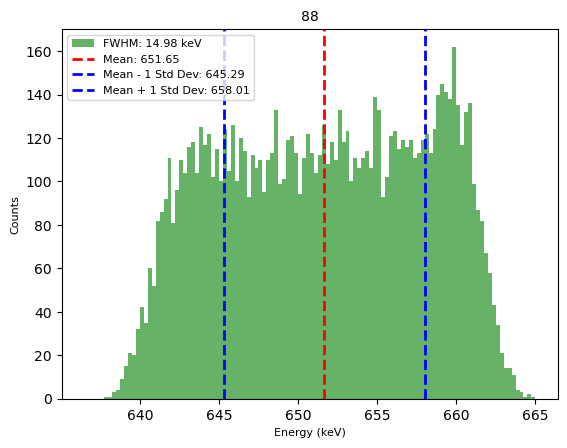

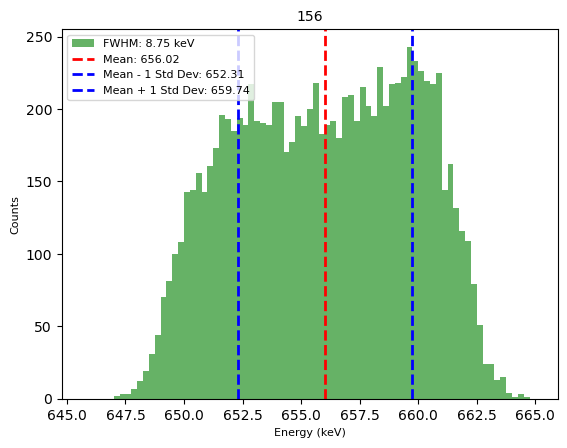

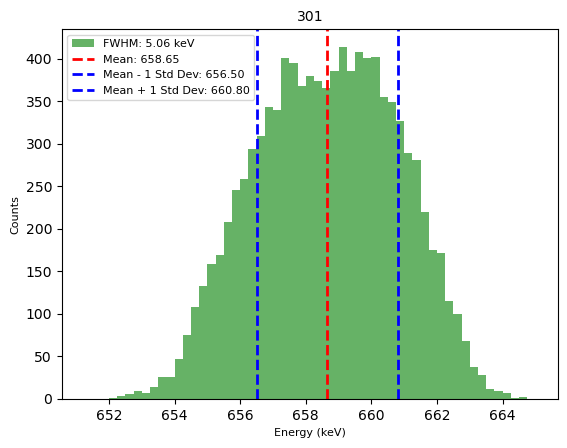

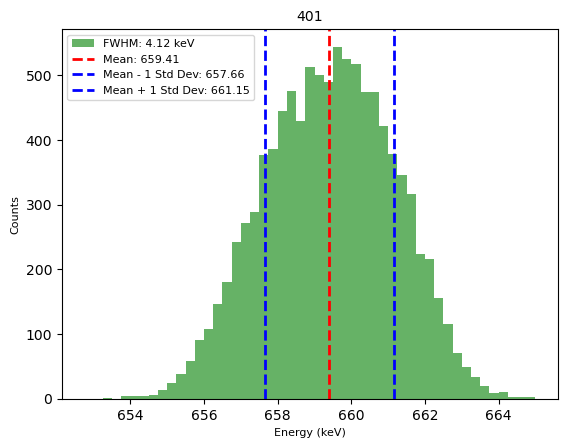

In [214]:

plotting_params_DC=  list(zip(exp_dc_array_list, exp_product_val))
plotting_params_AC=  list(zip(exp_ac_array_list, exp_product_val))

print(exp_product_val)

for param in plotting_params_DC:
    #plot DC strips
    fig, axs = plt.subplots() #define subplot
    if param[1]=="Room Temperature":
        mean_std(axs, param[0], param[1], RT=True)#we make special cuts for RT anneals bc the spectra are so weird
    else:
        mean_std(axs, param[0], param[1]) #for normal (semi-Gaussian) data sets


In [ ]:
std_mean()

[array([637.10552604, 653.06432278, 640.79261699, ..., 656.23012456,
       654.35692862, 655.30885371]), array([ 83.7118594, 611.179981 , 600.833123 , ..., 619.340957 ,
       640.368906 , 599.398778 ])]


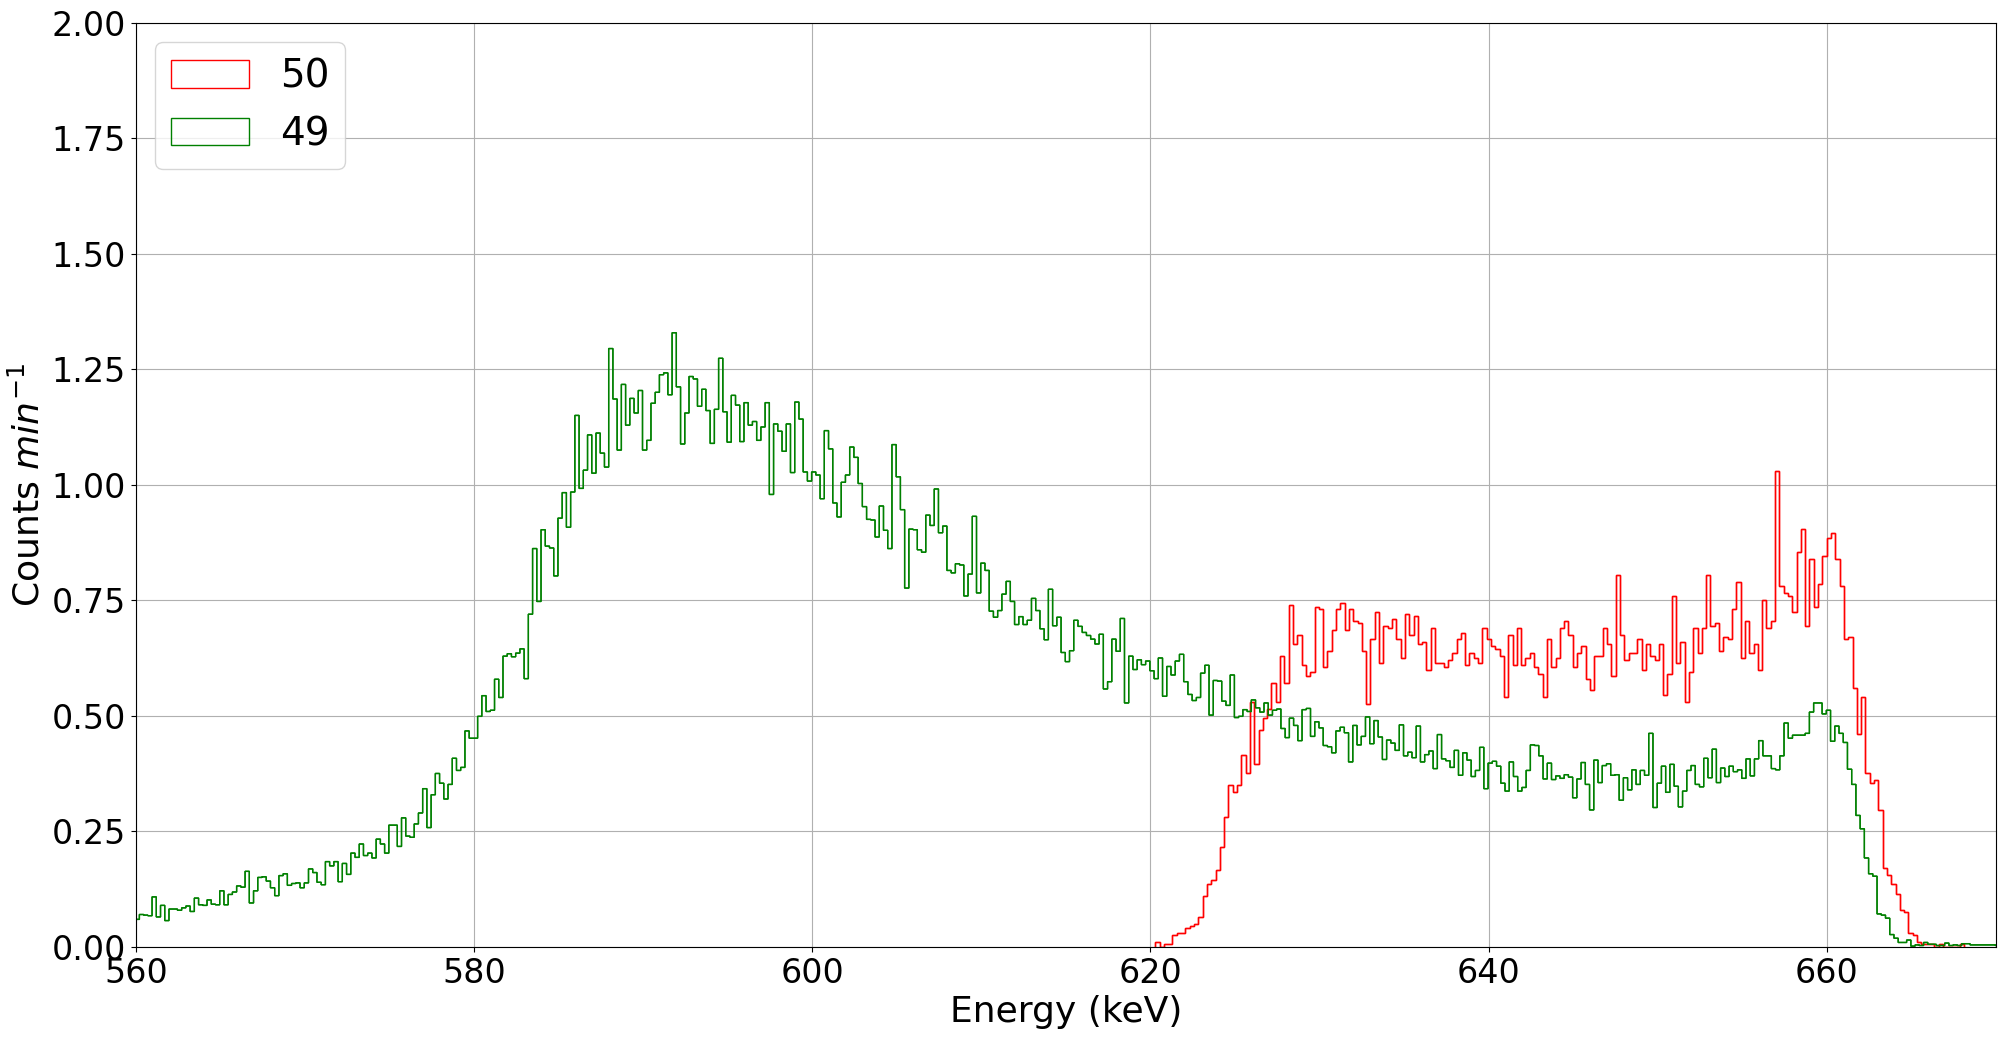

In [160]:
energies=[noised_50, anneal1]
min_energy=560
max_energy=670
min_count=0
max_count=2
exposure_time_list=[100, 380]
label_list=["50", "49"]
colors=['r', 'g']
print(energies)
multi_spline(energies, min_energy, max_energy, min_count, max_count,  exposure_time_list, label_list, colors, colordefault=False, log=False, Q_factor=False, vline=False)

[array([649.42698499, 654.5502778 , 655.79632585, ..., 654.75055257,
       642.75061725, 648.15587388]), array([625.755522 , 647.387145 , 645.714497 , ...,  78.9705413,
        83.1518517, 128.927403 ])]


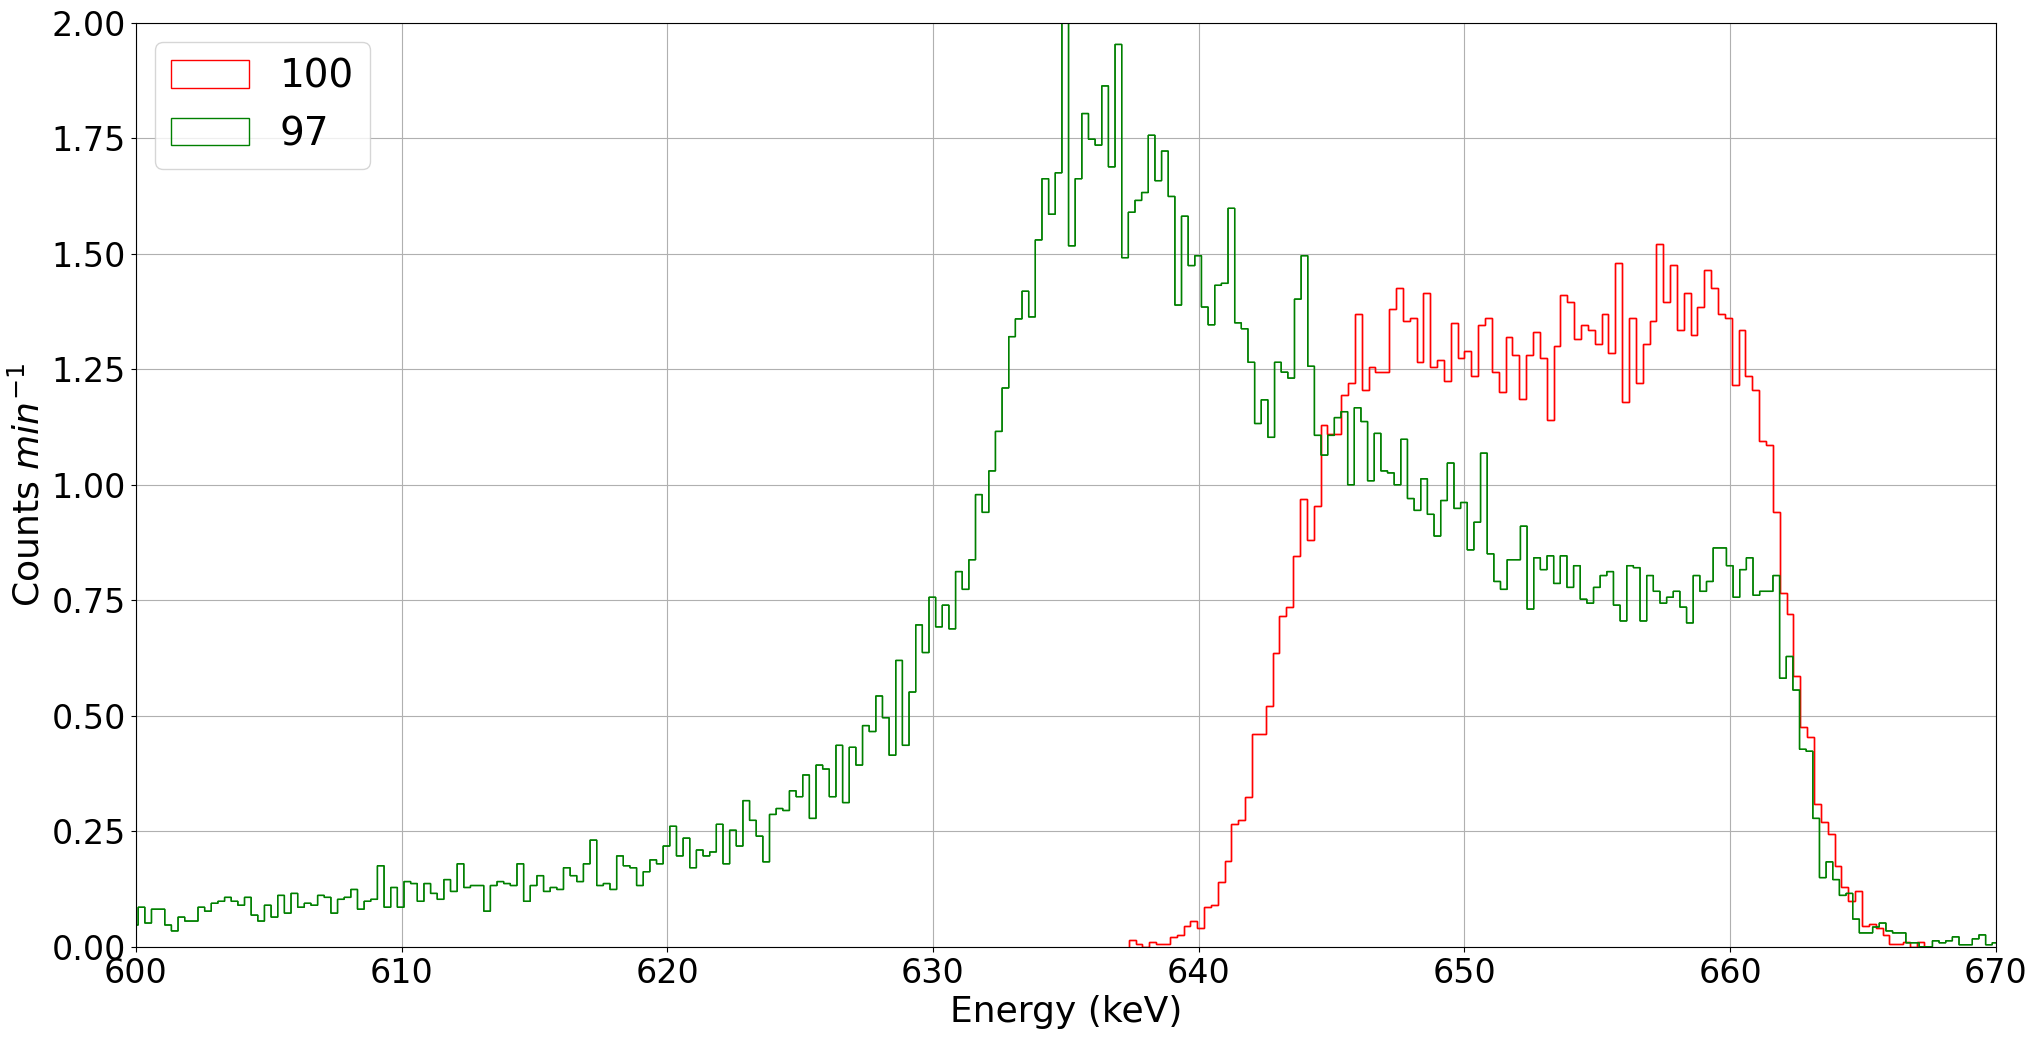

In [155]:
energies=[noised_100, anneal3]
min_energy=600
max_energy=670
min_count=0
max_count=2
exposure_time_list=[100, 117]
label_list=["100", "97"]
colors=['r', 'g']
print(energies)
multi_spline(energies, min_energy, max_energy, min_count, max_count,  exposure_time_list, label_list, colors, colordefault=False, log=False, Q_factor=False, vline=False)

[array([660.46890463, 661.56346084, 662.75670899, ..., 660.59817462,
       659.92372085, 660.62624646]), array([658.906555, 656.45145 , 661.478265, ..., 664.36697 , 628.180633,
       691.588613])]


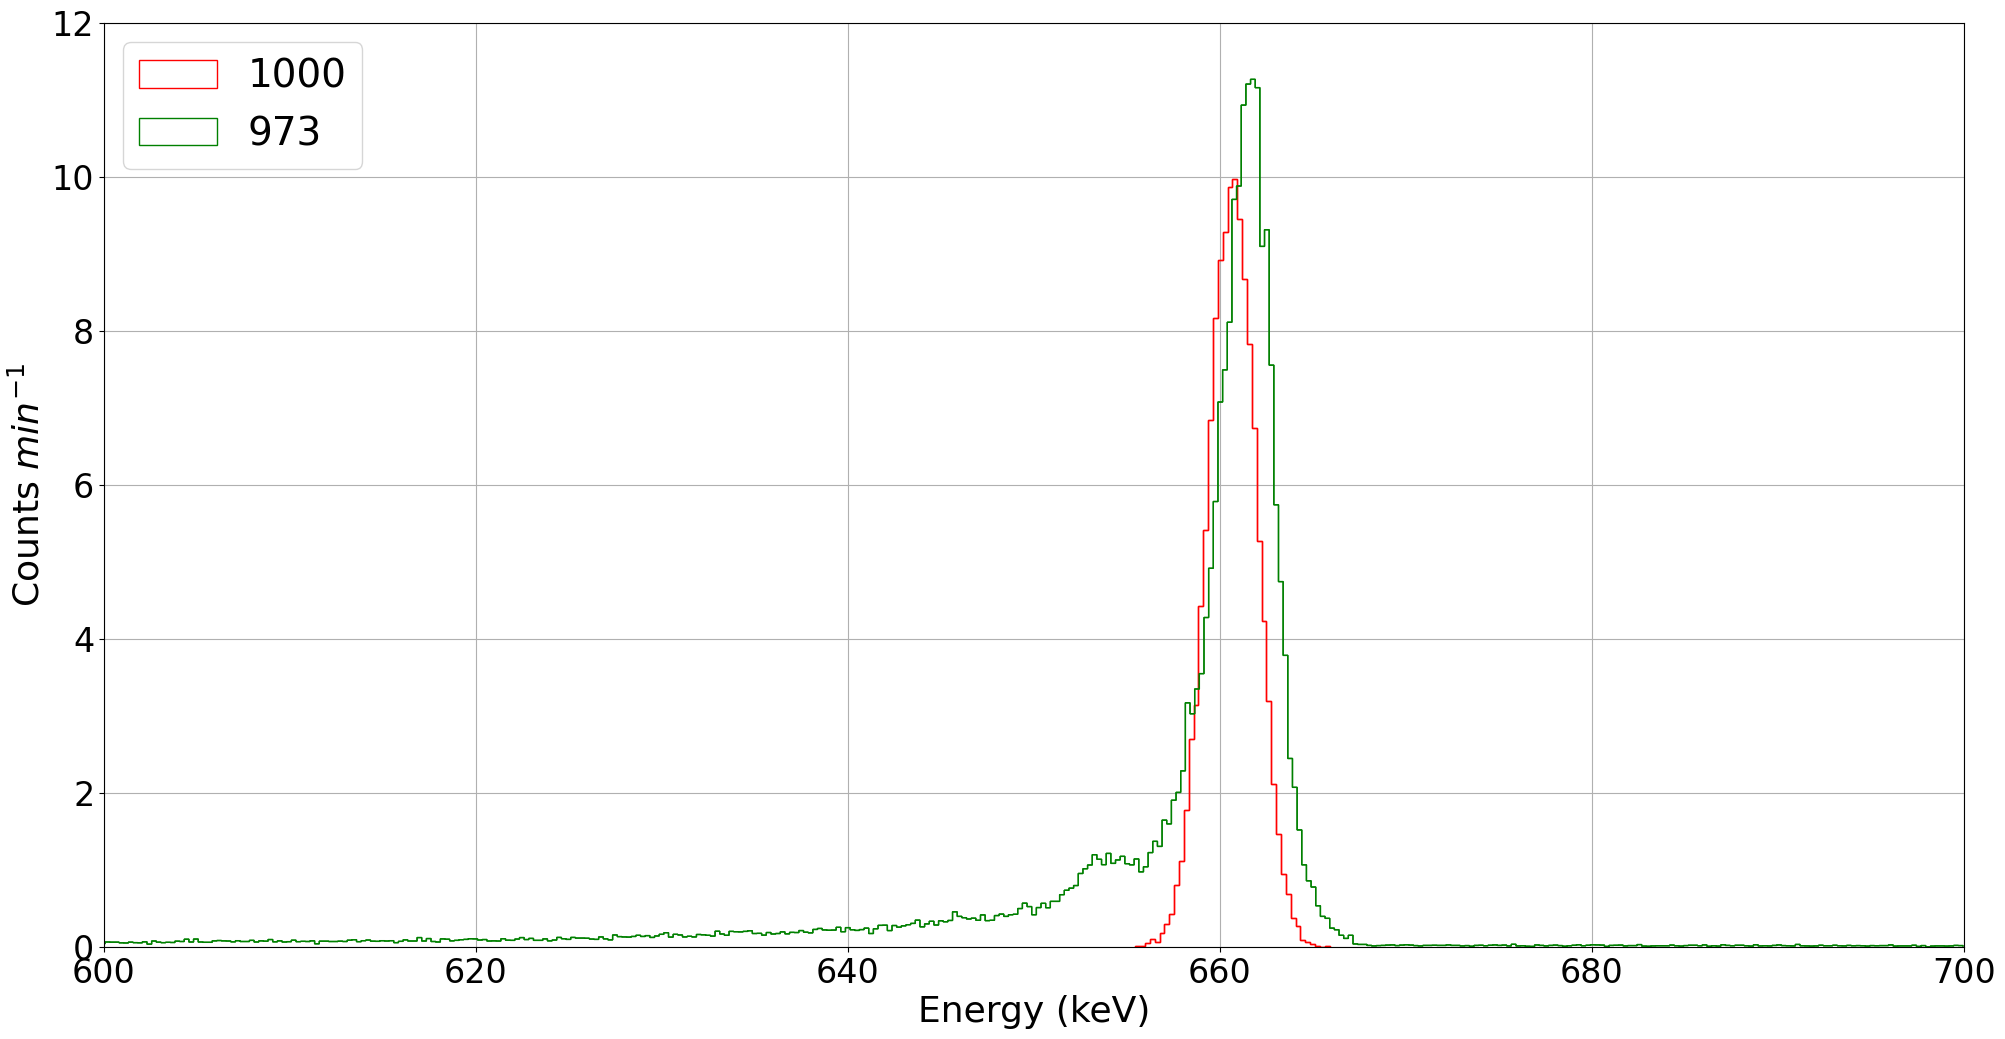

In [142]:
energies=[noised_1000, anneal6]
min_energy=600
max_energy=700
min_count=0
max_count=12
exposure_time_list=[80, 236]
label_list=["1000", "973"]
colors=['r', 'g']
print(energies)
multi_spline(energies, min_energy, max_energy, min_count, max_count,  exposure_time_list, label_list, colors, colordefault=False, log=False, Q_factor=False, vline=False)